In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [43]:
device= torch.device("cuda"if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [44]:
df=pd.read_csv("data/Sunspots.csv",index_col="Date",parse_dates=["Date"])
df

,Monthly_Mean_Sunspot
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0


In [45]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(df[['Monthly_Mean_Sunspot']])

# df['Monthly_Mean_Sunspot'] = scaler.transform(df[['Monthly_Mean_Sunspot']])

# Dataset Splitting

In [46]:
from sklearn.model_selection import train_test_split

In [47]:

ts_train, ts_test = train_test_split(df, test_size=0.2,shuffle=False)
ts_train.shape, ts_test.shape

((2612, 1), (653, 1))

# Dataset and Dataloader

In [48]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [49]:
seq_len= 12
bs=64

train_set= TimeSeriesDataset(ts_train,"Monthly_Mean_Sunspot",seq_len)
trainloader=DataLoader(train_set,batch_size=bs)

test_set=TimeSeriesDataset(ts_test,"Monthly_Mean_Sunspot",seq_len)
testloader= DataLoader(test_set,batch_size=bs)

(N, S, F): (217, 12, 1)
Note: last 7 data excluded

(N, S, F): (54, 12, 1)
Note: last 4 data excluded



# Arsitektur and Config

In [50]:
class LSTM (nn.Module):
    def __init__(self,input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.hidden= nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self,x,hidden):
        x,hidden= self.hidden(x,hidden)
        x= self.fc(x)
        return x,hidden

In [51]:
config = set_config({
    "batch_size" : bs,
    "seq_len" : train_set.n_seq,
    "input_size" : train_set.n_feature,
    "output_size" : 1,
    "hidden_size" : 64,
    "num_layers" : 2,
    "dropout": 0
})

# Training Preparation ~> MCOC

In [52]:
model = LSTM(config.input_size,config.output_size,config.hidden_size,config.num_layers,config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model,config,outdir="model")


# Training Loop

In [53]:
def loop_fn (mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
        
    cost = 0
    for feature,target in tqdm(dataloader,desc = mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature,None) 
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item()*feature.shape[0]
    cost=cost/len(dataset)
    return cost

In [54]:
from tqdm.auto import tqdm



Epoch     1
Train_cost  = 11051.6338 | Test_cost  = 12372.1631 | 




Epoch     2
Train_cost  = 11007.1099 | Test_cost  = 12321.3896 | 




Epoch     3
Train_cost  = 10956.9935 | Test_cost  = 12259.1904 | 




Epoch     4
Train_cost  = 10895.2523 | Test_cost  = 12181.7666 | 




Epoch     5
Train_cost  = 10818.8441 | Test_cost  = 12090.5000 | 




Epoch     6
Train_cost  = 10731.9495 | Test_cost  = 11992.8936 | 




Epoch     7
Train_cost  = 10640.3457 | Test_cost  = 11891.7705 | 




Epoch     8
Train_cost  = 10546.2270 | Test_cost  = 11789.9248 | 




Epoch     9
Train_cost  = 10452.6674 | Test_cost  = 11691.1455 | 




Epoch    10
Train_cost  = 10362.8372 | Test_cost  = 11597.5713 | 




Epoch    11
Train_cost  = 10278.6763 | Test_cost  = 11510.9414 | 




Epoch    12
Train_cost  = 10201.5868 | Test_cost  = 11432.1318 | 




Epoch    13
Train_cost  = 10131.5359 | Test_cost  = 11359.8516 | 




Epoch    14
Train_cost  = 10066.8360 | Test_cost  = 11292.0283 | 




Epoch    15
Train_cost  = 10006.1158 | Test_cost  = 11228.0303 | 




Epoch    16
Train_cost  = 9948.7226 | Test_cost  = 11167.2744 | 




Epoch    17
Train_cost  = 9894.0473 | Test_cost  = 11109.1953 | 




Epoch    18
Train_cost  = 9841.5434 | Test_cost  = 11052.9688 | 




Epoch    19
Train_cost  = 9790.7462 | Test_cost  = 10998.6562 | 




Epoch    20
Train_cost  = 9741.6571 | Test_cost  = 10946.0332 | 


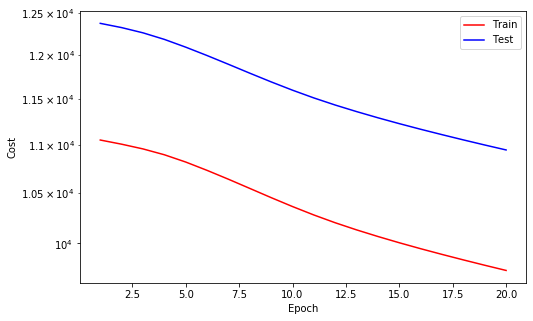



Epoch    21
Train_cost  = 9693.8915 | Test_cost  = 10894.4561 | 




Epoch    22
Train_cost  = 9646.9400 | Test_cost  = 10843.6895 | 




Epoch    23
Train_cost  = 9600.8180 | Test_cost  = 10794.2432 | 




Epoch    24
Train_cost  = 9555.9185 | Test_cost  = 10745.9668 | 




Epoch    25
Train_cost  = 9512.0625 | Test_cost  = 10698.7227 | 




Epoch    26
Train_cost  = 9469.1675 | Test_cost  = 10652.4844 | 




Epoch    27
Train_cost  = 9427.1642 | Test_cost  = 10607.1445 | 




Epoch    28
Train_cost  = 9385.9457 | Test_cost  = 10562.5625 | 




Epoch    29
Train_cost  = 9345.4131 | Test_cost  = 10518.6562 | 




Epoch    30
Train_cost  = 9305.4970 | Test_cost  = 10475.3730 | 




Epoch    31
Train_cost  = 9266.1459 | Test_cost  = 10432.6465 | 




Epoch    32
Train_cost  = 9227.3131 | Test_cost  = 10390.4453 | 




Epoch    33
Train_cost  = 9188.9746 | Test_cost  = 10348.7773 | 




Epoch    34
Train_cost  = 9151.1248 | Test_cost  = 10307.6094 | 




Epoch    35
Train_cost  = 9113.7347 | Test_cost  = 10266.9072 | 




Epoch    36
Train_cost  = 9076.7752 | Test_cost  = 10226.6504 | 




Epoch    37
Train_cost  = 9040.2240 | Test_cost  = 10186.8105 | 




Epoch    38
Train_cost  = 9004.0622 | Test_cost  = 10147.3721 | 




Epoch    39
Train_cost  = 8968.2745 | Test_cost  = 10108.3184 | 




Epoch    40
Train_cost  = 8932.8442 | Test_cost  = 10069.6367 | 


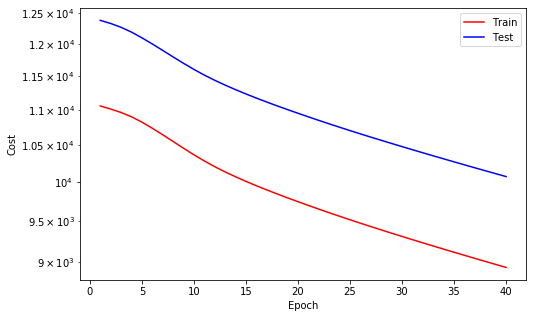



Epoch    41
Train_cost  = 8897.7585 | Test_cost  = 10031.3105 | 




Epoch    42
Train_cost  = 8863.0044 | Test_cost  = 9993.3271 | 




Epoch    43
Train_cost  = 8828.5692 | Test_cost  = 9955.6797 | 




Epoch    44
Train_cost  = 8794.4443 | Test_cost  = 9918.3516 | 




Epoch    45
Train_cost  = 8760.6131 | Test_cost  = 9881.3330 | 




Epoch    46
Train_cost  = 8727.0618 | Test_cost  = 9844.6162 | 




Epoch    47
Train_cost  = 8693.7690 | Test_cost  = 9808.1855 | 




Epoch    48
Train_cost  = 8660.7225 | Test_cost  = 9772.0312 | 




Epoch    49
Train_cost  = 8627.9070 | Test_cost  = 9736.1416 | 




Epoch    50
Train_cost  = 8595.2722 | Test_cost  = 9700.4785 | 




Epoch    51
Train_cost  = 8562.6775 | Test_cost  = 9664.9395 | 




Epoch    52
Train_cost  = 8529.7217 | Test_cost  = 9629.5166 | 




Epoch    53
Train_cost  = 8498.0176 | Test_cost  = 9593.8877 | 




Epoch    54
Train_cost  = 8466.1247 | Test_cost  = 9558.4238 | 




Epoch    55
Train_cost  = 8434.1159 | Test_cost  = 9522.9121 | 




Epoch    56
Train_cost  = 8401.8262 | Test_cost  = 9486.2891 | 




Epoch    57
Train_cost  = 8368.3329 | Test_cost  = 9447.6602 | 




Epoch    58
Train_cost  = 8334.7670 | Test_cost  = 9412.1230 | 




Epoch    59
Train_cost  = 8302.2454 | Test_cost  = 9376.7031 | 




Epoch    60
Train_cost  = 8271.0067 | Test_cost  = 9341.6602 | 


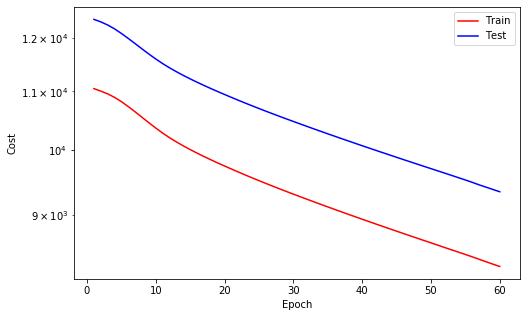



Epoch    61
Train_cost  = 8239.8063 | Test_cost  = 9307.5830 | 




Epoch    62
Train_cost  = 8209.0684 | Test_cost  = 9273.8516 | 




Epoch    63
Train_cost  = 8178.4154 | Test_cost  = 9240.5352 | 




Epoch    64
Train_cost  = 8147.9156 | Test_cost  = 9207.3994 | 




Epoch    65
Train_cost  = 8117.6032 | Test_cost  = 9174.2793 | 




Epoch    66
Train_cost  = 8087.4734 | Test_cost  = 9141.0674 | 




Epoch    67
Train_cost  = 8057.5643 | Test_cost  = 9108.1943 | 




Epoch    68
Train_cost  = 8027.8361 | Test_cost  = 9075.7412 | 




Epoch    69
Train_cost  = 7998.2757 | Test_cost  = 9043.4277 | 




Epoch    70
Train_cost  = 7968.8946 | Test_cost  = 9011.0762 | 




Epoch    71
Train_cost  = 7939.6865 | Test_cost  = 8978.9102 | 




Epoch    72
Train_cost  = 7910.6461 | Test_cost  = 8947.0176 | 




Epoch    73
Train_cost  = 7881.7716 | Test_cost  = 8915.3076 | 




Epoch    74
Train_cost  = 7853.0635 | Test_cost  = 8883.7891 | 




Epoch    75
Train_cost  = 7824.5176 | Test_cost  = 8852.4814 | 




Epoch    76
Train_cost  = 7796.1265 | Test_cost  = 8821.3145 | 




Epoch    77
Train_cost  = 7767.8943 | Test_cost  = 8790.2539 | 




Epoch    78
Train_cost  = 7739.8164 | Test_cost  = 8759.3428 | 




Epoch    79
Train_cost  = 7711.8816 | Test_cost  = 8728.6055 | 




Epoch    80
Train_cost  = 7684.0882 | Test_cost  = 8698.0400 | 


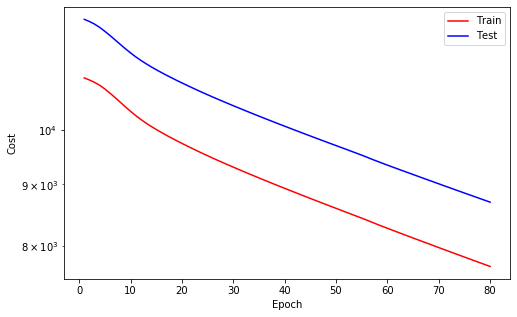



Epoch    81
Train_cost  = 7656.4335 | Test_cost  = 8667.6602 | 




Epoch    82
Train_cost  = 7628.9112 | Test_cost  = 8637.4502 | 




Epoch    83
Train_cost  = 7601.5270 | Test_cost  = 8607.3945 | 




Epoch    84
Train_cost  = 7574.2792 | Test_cost  = 8577.5020 | 




Epoch    85
Train_cost  = 7547.1690 | Test_cost  = 8547.7334 | 




Epoch    86
Train_cost  = 7520.1987 | Test_cost  = 8518.0713 | 




Epoch    87
Train_cost  = 7493.3648 | Test_cost  = 8488.5088 | 




Epoch    88
Train_cost  = 7466.6674 | Test_cost  = 8459.0791 | 




Epoch    89
Train_cost  = 7440.1051 | Test_cost  = 8429.7852 | 




Epoch    90
Train_cost  = 7413.6794 | Test_cost  = 8400.6152 | 




Epoch    91
Train_cost  = 7387.3865 | Test_cost  = 8371.5820 | 




Epoch    92
Train_cost  = 7361.2217 | Test_cost  = 8342.6816 | 




Epoch    93
Train_cost  = 7335.1848 | Test_cost  = 8313.9209 | 




Epoch    94
Train_cost  = 7309.2714 | Test_cost  = 8285.2480 | 




Epoch    95
Train_cost  = 7283.4798 | Test_cost  = 8256.6650 | 




Epoch    96
Train_cost  = 7257.8049 | Test_cost  = 8228.1709 | 




Epoch    97
Train_cost  = 7232.2494 | Test_cost  = 8199.8105 | 




Epoch    98
Train_cost  = 7206.8136 | Test_cost  = 8171.5801 | 




Epoch    99
Train_cost  = 7181.4969 | Test_cost  = 8143.4814 | 




Epoch   100
Train_cost  = 7156.3007 | Test_cost  = 8115.5068 | 


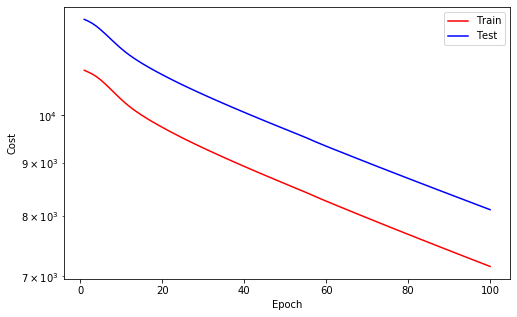



Epoch   101
Train_cost  = 7131.2206 | Test_cost  = 8087.6274 | 




Epoch   102
Train_cost  = 7106.2523 | Test_cost  = 8059.8760 | 




Epoch   103
Train_cost  = 7081.3960 | Test_cost  = 8032.2305 | 




Epoch   104
Train_cost  = 7056.6539 | Test_cost  = 8004.7778 | 




Epoch   105
Train_cost  = 7032.0211 | Test_cost  = 7977.3613 | 




Epoch   106
Train_cost  = 7007.5082 | Test_cost  = 7950.2139 | 




Epoch   107
Train_cost  = 6983.0983 | Test_cost  = 7922.9897 | 




Epoch   108
Train_cost  = 6958.8114 | Test_cost  = 7896.1606 | 




Epoch   109
Train_cost  = 6934.6199 | Test_cost  = 7869.0718 | 




Epoch   110
Train_cost  = 6910.5392 | Test_cost  = 7842.5601 | 




Epoch   111
Train_cost  = 6886.5634 | Test_cost  = 7815.6533 | 




Epoch   112
Train_cost  = 6862.6852 | Test_cost  = 7789.4272 | 




Epoch   113
Train_cost  = 6838.9290 | Test_cost  = 7762.8228 | 




Epoch   114
Train_cost  = 6815.2352 | Test_cost  = 7736.8149 | 




Epoch   115
Train_cost  = 6791.7003 | Test_cost  = 7710.5229 | 




Epoch   116
Train_cost  = 6768.2063 | Test_cost  = 7684.6104 | 




Epoch   117
Train_cost  = 6744.8872 | Test_cost  = 7658.5156 | 




Epoch   118
Train_cost  = 6721.6097 | Test_cost  = 7633.0132 | 




Epoch   119
Train_cost  = 6698.5000 | Test_cost  = 7607.1167 | 




Epoch   120
Train_cost  = 6675.4198 | Test_cost  = 7581.7271 | 


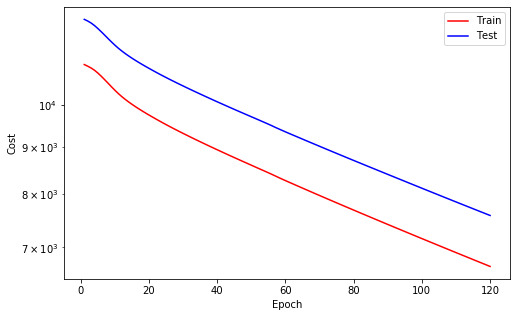



Epoch   121
Train_cost  = 6652.5496 | Test_cost  = 7556.4229 | 




Epoch   122
Train_cost  = 6629.6954 | Test_cost  = 7530.9092 | 




Epoch   123
Train_cost  = 6606.9476 | Test_cost  = 7505.5981 | 




Epoch   124
Train_cost  = 6584.3333 | Test_cost  = 7480.5786 | 




Epoch   125
Train_cost  = 6561.8511 | Test_cost  = 7455.8115 | 




Epoch   126
Train_cost  = 6539.6686 | Test_cost  = 7431.2124 | 




Epoch   127
Train_cost  = 6517.5493 | Test_cost  = 7406.1812 | 




Epoch   128
Train_cost  = 6495.7430 | Test_cost  = 7381.9917 | 




Epoch   129
Train_cost  = 6473.7001 | Test_cost  = 7355.6821 | 




Epoch   130
Train_cost  = 6451.8494 | Test_cost  = 7329.8022 | 




Epoch   131
Train_cost  = 6429.8799 | Test_cost  = 7309.2993 | 




Epoch   132
Train_cost  = 6408.2946 | Test_cost  = 7283.3921 | 




Epoch   133
Train_cost  = 6386.4358 | Test_cost  = 7257.9800 | 




Epoch   134
Train_cost  = 6364.0749 | Test_cost  = 7234.4629 | 




Epoch   135
Train_cost  = 6342.6071 | Test_cost  = 7209.8247 | 




Epoch   136
Train_cost  = 6321.0582 | Test_cost  = 7184.9717 | 




Epoch   137
Train_cost  = 6299.7172 | Test_cost  = 7162.2661 | 




Epoch   138
Train_cost  = 6278.4203 | Test_cost  = 7139.1089 | 




Epoch   139
Train_cost  = 6257.2380 | Test_cost  = 7114.7583 | 




Epoch   140
Train_cost  = 6236.1953 | Test_cost  = 7090.6567 | 


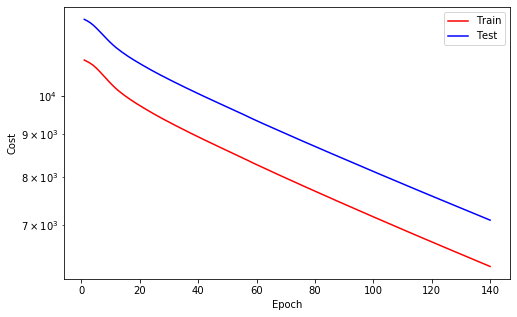



Epoch   141
Train_cost  = 6214.9012 | Test_cost  = 7068.0811 | 




Epoch   142
Train_cost  = 6193.9915 | Test_cost  = 7044.6743 | 




Epoch   143
Train_cost  = 6173.0879 | Test_cost  = 7021.5811 | 




Epoch   144
Train_cost  = 6152.2681 | Test_cost  = 6998.1792 | 




Epoch   145
Train_cost  = 6131.6322 | Test_cost  = 6975.8579 | 




Epoch   146
Train_cost  = 6111.0101 | Test_cost  = 6952.1396 | 




Epoch   147
Train_cost  = 6090.5287 | Test_cost  = 6930.2900 | 




Epoch   148
Train_cost  = 6070.0497 | Test_cost  = 6907.1064 | 




Epoch   149
Train_cost  = 6049.6578 | Test_cost  = 6884.8228 | 




Epoch   150
Train_cost  = 6029.3951 | Test_cost  = 6862.6753 | 




Epoch   151
Train_cost  = 6009.2680 | Test_cost  = 6840.2261 | 




Epoch   152
Train_cost  = 5989.1567 | Test_cost  = 6818.5562 | 




Epoch   153
Train_cost  = 5969.3581 | Test_cost  = 6796.2036 | 




Epoch   154
Train_cost  = 5949.3721 | Test_cost  = 6774.1211 | 




Epoch   155
Train_cost  = 5929.7845 | Test_cost  = 6753.0044 | 




Epoch   156
Train_cost  = 5909.9215 | Test_cost  = 6730.4736 | 




Epoch   157
Train_cost  = 5890.4071 | Test_cost  = 6708.8867 | 




Epoch   158
Train_cost  = 5870.8109 | Test_cost  = 6688.0693 | 




Epoch   159
Train_cost  = 5851.5195 | Test_cost  = 6667.4692 | 




Epoch   160
Train_cost  = 5832.2950 | Test_cost  = 6644.2246 | 


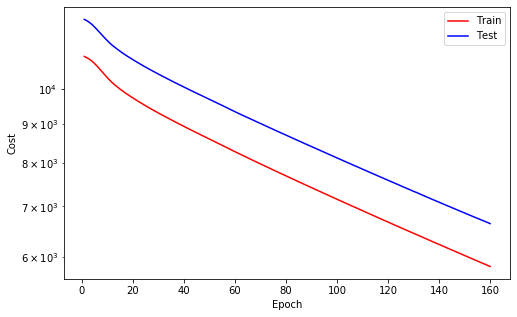



Epoch   161
Train_cost  = 5812.9469 | Test_cost  = 6624.0068 | 




Epoch   162
Train_cost  = 5793.4516 | Test_cost  = 6603.5063 | 




Epoch   163
Train_cost  = 5774.4583 | Test_cost  = 6580.1699 | 




Epoch   164
Train_cost  = 5755.2196 | Test_cost  = 6561.1519 | 




Epoch   165
Train_cost  = 5736.1891 | Test_cost  = 6539.4390 | 




Epoch   166
Train_cost  = 5717.0744 | Test_cost  = 6518.3486 | 




Epoch   167
Train_cost  = 5698.3639 | Test_cost  = 6498.6479 | 




Epoch   168
Train_cost  = 5679.5238 | Test_cost  = 6478.0137 | 




Epoch   169
Train_cost  = 5660.7970 | Test_cost  = 6456.0708 | 




Epoch   170
Train_cost  = 5642.2074 | Test_cost  = 6436.9678 | 




Epoch   171
Train_cost  = 5623.9422 | Test_cost  = 6417.7598 | 




Epoch   172
Train_cost  = 5606.0017 | Test_cost  = 6393.0654 | 




Epoch   173
Train_cost  = 5587.3551 | Test_cost  = 6375.4990 | 




Epoch   174
Train_cost  = 5569.1256 | Test_cost  = 6355.7422 | 




Epoch   175
Train_cost  = 5551.0655 | Test_cost  = 6333.3726 | 




Epoch   176
Train_cost  = 5532.6612 | Test_cost  = 6314.1357 | 




Epoch   177
Train_cost  = 5514.3564 | Test_cost  = 6296.0635 | 




Epoch   178
Train_cost  = 5496.2572 | Test_cost  = 6273.8604 | 




Epoch   179
Train_cost  = 5478.2498 | Test_cost  = 6255.5815 | 




Epoch   180
Train_cost  = 5460.5455 | Test_cost  = 6236.1841 | 


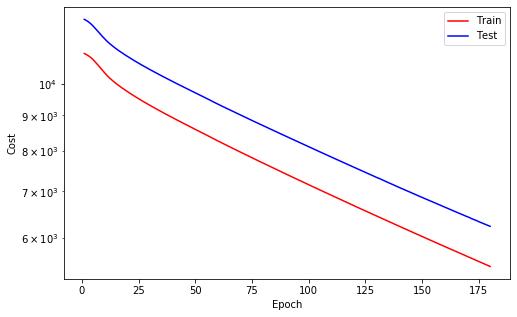



Epoch   181
Train_cost  = 5442.8195 | Test_cost  = 6214.9429 | 




Epoch   182
Train_cost  = 5424.9460 | Test_cost  = 6195.4805 | 




Epoch   183
Train_cost  = 5407.3474 | Test_cost  = 6177.0083 | 




Epoch   184
Train_cost  = 5390.2031 | Test_cost  = 6159.2163 | 




Epoch   185
Train_cost  = 5373.2979 | Test_cost  = 6133.7700 | 




Epoch   186
Train_cost  = 5355.6624 | Test_cost  = 6118.0137 | 




Epoch   187
Train_cost  = 5339.1205 | Test_cost  = 6101.0752 | 




Epoch   188
Train_cost  = 5322.6576 | Test_cost  = 6075.5547 | 




Epoch   189
Train_cost  = 5304.6851 | Test_cost  = 6060.0493 | 




Epoch   190
Train_cost  = 5287.0806 | Test_cost  = 6039.7959 | 




Epoch   191
Train_cost  = 5270.3788 | Test_cost  = 6020.6714 | 




Epoch   192
Train_cost  = 5253.0527 | Test_cost  = 6002.4180 | 




Epoch   193
Train_cost  = 5236.1412 | Test_cost  = 5982.5723 | 




Epoch   194
Train_cost  = 5218.5347 | Test_cost  = 5963.2153 | 




Epoch   195
Train_cost  = 5202.1689 | Test_cost  = 5946.4614 | 




Epoch   196
Train_cost  = 5185.2400 | Test_cost  = 5927.4370 | 




Epoch   197
Train_cost  = 5168.5106 | Test_cost  = 5909.4209 | 




Epoch   198
Train_cost  = 5151.9694 | Test_cost  = 5889.5200 | 




Epoch   199
Train_cost  = 5135.3520 | Test_cost  = 5872.8960 | 




Epoch   200
Train_cost  = 5119.1554 | Test_cost  = 5855.4844 | 


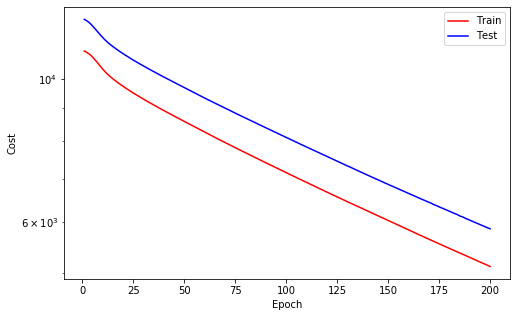



Epoch   201
Train_cost  = 5102.8545 | Test_cost  = 5835.4028 | 




Epoch   202
Train_cost  = 5086.3849 | Test_cost  = 5818.0942 | 




Epoch   203
Train_cost  = 5070.8853 | Test_cost  = 5800.3970 | 




Epoch   204
Train_cost  = 5054.4192 | Test_cost  = 5783.1465 | 




Epoch   205
Train_cost  = 5038.6961 | Test_cost  = 5762.2593 | 




Epoch   206
Train_cost  = 5022.8497 | Test_cost  = 5745.6157 | 




Epoch   207
Train_cost  = 5007.4553 | Test_cost  = 5729.2661 | 




Epoch   208
Train_cost  = 4992.4855 | Test_cost  = 5708.7598 | 




Epoch   209
Train_cost  = 4976.3634 | Test_cost  = 5690.4316 | 




Epoch   210
Train_cost  = 4960.5393 | Test_cost  = 5675.4419 | 




Epoch   211
Train_cost  = 4944.7367 | Test_cost  = 5653.7729 | 




Epoch   212
Train_cost  = 4928.5718 | Test_cost  = 5637.7563 | 




Epoch   213
Train_cost  = 4913.6805 | Test_cost  = 5621.2930 | 




Epoch   214
Train_cost  = 4898.3370 | Test_cost  = 5600.7681 | 




Epoch   215
Train_cost  = 4882.4864 | Test_cost  = 5587.9839 | 




Epoch   216
Train_cost  = 4867.5372 | Test_cost  = 5567.9795 | 




Epoch   217
Train_cost  = 4851.4675 | Test_cost  = 5549.6055 | 




Epoch   218
Train_cost  = 4836.1921 | Test_cost  = 5535.0977 | 




Epoch   219
Train_cost  = 4820.9869 | Test_cost  = 5517.2749 | 




Epoch   220
Train_cost  = 4805.9591 | Test_cost  = 5500.1479 | 


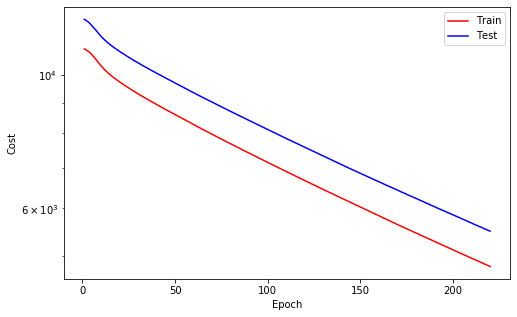



Epoch   221
Train_cost  = 4790.7592 | Test_cost  = 5484.2695 | 




Epoch   222
Train_cost  = 4776.3318 | Test_cost  = 5467.2700 | 




Epoch   223
Train_cost  = 4761.2338 | Test_cost  = 5449.7974 | 




Epoch   224
Train_cost  = 4746.2362 | Test_cost  = 5434.6094 | 




Epoch   225
Train_cost  = 4731.5179 | Test_cost  = 5415.6992 | 




Epoch   226
Train_cost  = 4716.7559 | Test_cost  = 5400.9326 | 




Epoch   227
Train_cost  = 4702.2700 | Test_cost  = 5384.4570 | 




Epoch   228
Train_cost  = 4687.4783 | Test_cost  = 5368.8730 | 




Epoch   229
Train_cost  = 4672.9606 | Test_cost  = 5352.3833 | 




Epoch   230
Train_cost  = 4658.2307 | Test_cost  = 5334.6313 | 




Epoch   231
Train_cost  = 4643.5928 | Test_cost  = 5319.8408 | 




Epoch   232
Train_cost  = 4629.1017 | Test_cost  = 5302.6538 | 




Epoch   233
Train_cost  = 4614.4430 | Test_cost  = 5287.7974 | 




Epoch   234
Train_cost  = 4600.0597 | Test_cost  = 5271.4487 | 




Epoch   235
Train_cost  = 4585.8137 | Test_cost  = 5255.0645 | 




Epoch   236
Train_cost  = 4571.4980 | Test_cost  = 5239.9292 | 




Epoch   237
Train_cost  = 4557.4650 | Test_cost  = 5224.4634 | 




Epoch   238
Train_cost  = 4543.5682 | Test_cost  = 5209.6538 | 




Epoch   239
Train_cost  = 4529.6708 | Test_cost  = 5192.2944 | 




Epoch   240
Train_cost  = 4516.2540 | Test_cost  = 5175.8223 | 


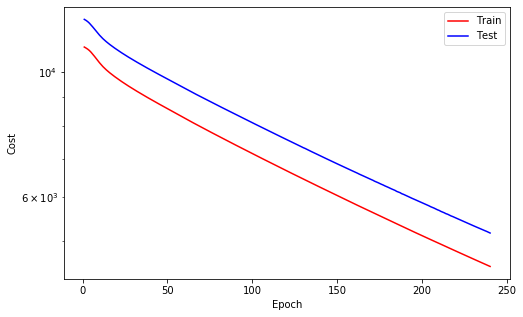



Epoch   241
Train_cost  = 4502.3443 | Test_cost  = 5165.2466 | 




Epoch   242
Train_cost  = 4490.0697 | Test_cost  = 5144.0117 | 




Epoch   243
Train_cost  = 4475.9926 | Test_cost  = 5128.0078 | 




Epoch   244
Train_cost  = 4463.1273 | Test_cost  = 5117.0142 | 




Epoch   245
Train_cost  = 4449.7559 | Test_cost  = 5094.8594 | 




Epoch   246
Train_cost  = 4436.0488 | Test_cost  = 5082.3237 | 




Epoch   247
Train_cost  = 4421.0844 | Test_cost  = 5066.7896 | 




Epoch   248
Train_cost  = 4407.5004 | Test_cost  = 5045.0835 | 




Epoch   249
Train_cost  = 4393.6775 | Test_cost  = 5041.5835 | 




Epoch   250
Train_cost  = 4380.2782 | Test_cost  = 5016.6045 | 




Epoch   251
Train_cost  = 4366.7377 | Test_cost  = 5006.3774 | 




Epoch   252
Train_cost  = 4352.7088 | Test_cost  = 4987.9556 | 




Epoch   253
Train_cost  = 4339.2962 | Test_cost  = 4970.8027 | 




Epoch   254
Train_cost  = 4325.9128 | Test_cost  = 4961.5122 | 




Epoch   255
Train_cost  = 4312.6192 | Test_cost  = 4942.9297 | 




Epoch   256
Train_cost  = 4299.6510 | Test_cost  = 4929.5952 | 




Epoch   257
Train_cost  = 4286.8445 | Test_cost  = 4915.1221 | 




Epoch   258
Train_cost  = 4273.4747 | Test_cost  = 4897.8574 | 




Epoch   259
Train_cost  = 4260.6992 | Test_cost  = 4888.8877 | 




Epoch   260
Train_cost  = 4247.6681 | Test_cost  = 4869.4692 | 


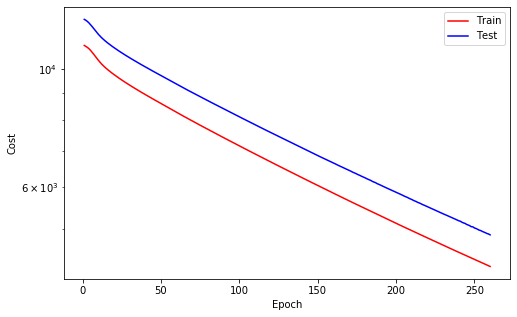



Epoch   261
Train_cost  = 4234.3736 | Test_cost  = 4857.7510 | 




Epoch   262
Train_cost  = 4221.7241 | Test_cost  = 4841.8750 | 




Epoch   263
Train_cost  = 4209.3658 | Test_cost  = 4829.5454 | 




Epoch   264
Train_cost  = 4196.1922 | Test_cost  = 4813.9331 | 




Epoch   265
Train_cost  = 4184.2832 | Test_cost  = 4800.5176 | 




Epoch   266
Train_cost  = 4171.6769 | Test_cost  = 4782.0225 | 




Epoch   267
Train_cost  = 4159.3066 | Test_cost  = 4776.8042 | 




Epoch   268
Train_cost  = 4146.3001 | Test_cost  = 4756.2764 | 




Epoch   269
Train_cost  = 4134.1142 | Test_cost  = 4745.7534 | 




Epoch   270
Train_cost  = 4121.4495 | Test_cost  = 4727.7046 | 




Epoch   271
Train_cost  = 4109.3500 | Test_cost  = 4717.8633 | 




Epoch   272
Train_cost  = 4096.4935 | Test_cost  = 4700.2134 | 




Epoch   273
Train_cost  = 4084.4481 | Test_cost  = 4687.5615 | 




Epoch   274
Train_cost  = 4071.8802 | Test_cost  = 4672.6035 | 




Epoch   275
Train_cost  = 4059.6582 | Test_cost  = 4659.8608 | 




Epoch   276
Train_cost  = 4047.4910 | Test_cost  = 4644.9185 | 




Epoch   277
Train_cost  = 4035.6587 | Test_cost  = 4632.8525 | 




Epoch   278
Train_cost  = 4023.4660 | Test_cost  = 4617.5908 | 




Epoch   279
Train_cost  = 4011.4987 | Test_cost  = 4605.5327 | 




Epoch   280
Train_cost  = 3999.7693 | Test_cost  = 4590.7393 | 


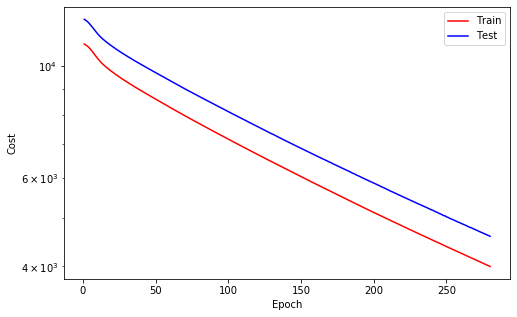



Epoch   281
Train_cost  = 3987.6577 | Test_cost  = 4579.9663 | 




Epoch   282
Train_cost  = 3975.5153 | Test_cost  = 4564.4424 | 




Epoch   283
Train_cost  = 3964.2576 | Test_cost  = 4551.4521 | 




Epoch   284
Train_cost  = 3952.3820 | Test_cost  = 4538.0771 | 




Epoch   285
Train_cost  = 3940.8087 | Test_cost  = 4525.3003 | 




Epoch   286
Train_cost  = 3929.6314 | Test_cost  = 4511.7695 | 




Epoch   287
Train_cost  = 3918.1375 | Test_cost  = 4498.2573 | 




Epoch   288
Train_cost  = 3907.3600 | Test_cost  = 4485.2617 | 




Epoch   289
Train_cost  = 3895.1963 | Test_cost  = 4472.2085 | 




Epoch   290
Train_cost  = 3884.9468 | Test_cost  = 4455.9902 | 




Epoch   291
Train_cost  = 3873.6499 | Test_cost  = 4449.5430 | 




Epoch   292
Train_cost  = 3861.4435 | Test_cost  = 4433.5234 | 




Epoch   293
Train_cost  = 3850.4650 | Test_cost  = 4417.7812 | 




Epoch   294
Train_cost  = 3838.6861 | Test_cost  = 4406.5088 | 




Epoch   295
Train_cost  = 3827.2666 | Test_cost  = 4395.2876 | 




Epoch   296
Train_cost  = 3816.6382 | Test_cost  = 4378.2710 | 




Epoch   297
Train_cost  = 3805.3759 | Test_cost  = 4368.5615 | 




Epoch   298
Train_cost  = 3793.5235 | Test_cost  = 4356.2002 | 




Epoch   299
Train_cost  = 3783.1485 | Test_cost  = 4340.7495 | 




Epoch   300
Train_cost  = 3771.8513 | Test_cost  = 4329.9722 | 


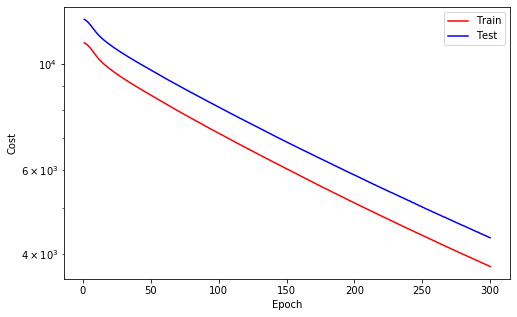



Epoch   301
Train_cost  = 3760.7231 | Test_cost  = 4318.7432 | 




Epoch   302
Train_cost  = 3749.4515 | Test_cost  = 4303.7427 | 




Epoch   303
Train_cost  = 3738.7309 | Test_cost  = 4291.4409 | 




Epoch   304
Train_cost  = 3727.1917 | Test_cost  = 4277.9463 | 




Epoch   305
Train_cost  = 3716.8035 | Test_cost  = 4266.1357 | 




Epoch   306
Train_cost  = 3706.1757 | Test_cost  = 4253.9951 | 




Epoch   307
Train_cost  = 3695.4801 | Test_cost  = 4242.7036 | 




Epoch   308
Train_cost  = 3684.6143 | Test_cost  = 4228.8193 | 




Epoch   309
Train_cost  = 3674.2527 | Test_cost  = 4216.8330 | 




Epoch   310
Train_cost  = 3663.0510 | Test_cost  = 4205.1665 | 




Epoch   311
Train_cost  = 3653.1232 | Test_cost  = 4192.7417 | 




Epoch   312
Train_cost  = 3642.4579 | Test_cost  = 4180.8345 | 




Epoch   313
Train_cost  = 3632.1092 | Test_cost  = 4169.6055 | 




Epoch   314
Train_cost  = 3621.1533 | Test_cost  = 4155.9663 | 




Epoch   315
Train_cost  = 3611.5317 | Test_cost  = 4145.3335 | 




Epoch   316
Train_cost  = 3601.4954 | Test_cost  = 4134.0615 | 




Epoch   317
Train_cost  = 3591.2651 | Test_cost  = 4119.8843 | 




Epoch   318
Train_cost  = 3582.1678 | Test_cost  = 4108.2129 | 




Epoch   319
Train_cost  = 3571.8747 | Test_cost  = 4098.2759 | 




Epoch   320
Train_cost  = 3560.9257 | Test_cost  = 4083.9209 | 


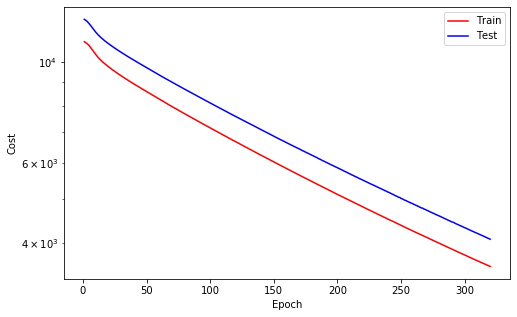



Epoch   321
Train_cost  = 3550.7682 | Test_cost  = 4072.3545 | 




Epoch   322
Train_cost  = 3540.4616 | Test_cost  = 4060.9011 | 




Epoch   323
Train_cost  = 3530.3929 | Test_cost  = 4048.3157 | 




Epoch   324
Train_cost  = 3520.1347 | Test_cost  = 4038.0354 | 




Epoch   325
Train_cost  = 3510.1601 | Test_cost  = 4022.1602 | 




Epoch   326
Train_cost  = 3500.8677 | Test_cost  = 4012.7781 | 




Epoch   327
Train_cost  = 3491.6663 | Test_cost  = 4005.4919 | 




Epoch   328
Train_cost  = 3481.6622 | Test_cost  = 3988.6116 | 




Epoch   329
Train_cost  = 3472.3578 | Test_cost  = 3977.3530 | 




Epoch   330
Train_cost  = 3461.8804 | Test_cost  = 3965.1528 | 




Epoch   331
Train_cost  = 3452.4610 | Test_cost  = 3953.9102 | 




Epoch   332
Train_cost  = 3443.5631 | Test_cost  = 3943.4368 | 




Epoch   333
Train_cost  = 3433.7826 | Test_cost  = 3934.0154 | 




Epoch   334
Train_cost  = 3423.1798 | Test_cost  = 3918.7017 | 




Epoch   335
Train_cost  = 3413.2418 | Test_cost  = 3908.2759 | 




Epoch   336
Train_cost  = 3403.5577 | Test_cost  = 3895.9482 | 




Epoch   337
Train_cost  = 3393.5719 | Test_cost  = 3885.0679 | 




Epoch   338
Train_cost  = 3384.4942 | Test_cost  = 3875.7632 | 




Epoch   339
Train_cost  = 3374.3494 | Test_cost  = 3861.5305 | 




Epoch   340
Train_cost  = 3364.6221 | Test_cost  = 3851.0378 | 


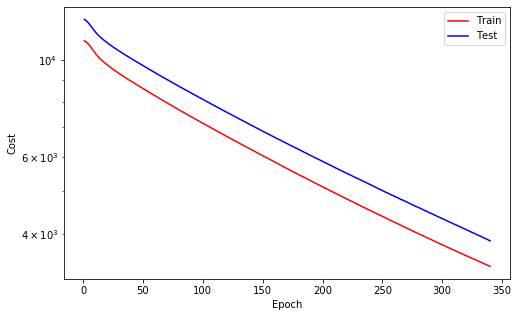



Epoch   341
Train_cost  = 3355.0142 | Test_cost  = 3841.5007 | 




Epoch   342
Train_cost  = 3345.1936 | Test_cost  = 3829.7568 | 




Epoch   343
Train_cost  = 3335.9682 | Test_cost  = 3820.6675 | 




Epoch   344
Train_cost  = 3326.5750 | Test_cost  = 3808.8535 | 




Epoch   345
Train_cost  = 3317.4808 | Test_cost  = 3798.4436 | 




Epoch   346
Train_cost  = 3308.1946 | Test_cost  = 3788.3506 | 




Epoch   347
Train_cost  = 3299.1715 | Test_cost  = 3777.8569 | 




Epoch   348
Train_cost  = 3290.1514 | Test_cost  = 3767.5491 | 




Epoch   349
Train_cost  = 3281.1995 | Test_cost  = 3758.2581 | 




Epoch   350
Train_cost  = 3272.6511 | Test_cost  = 3746.7974 | 




Epoch   351
Train_cost  = 3263.2707 | Test_cost  = 3736.7214 | 




Epoch   352
Train_cost  = 3254.3619 | Test_cost  = 3727.7678 | 




Epoch   353
Train_cost  = 3245.3481 | Test_cost  = 3714.7615 | 




Epoch   354
Train_cost  = 3236.9084 | Test_cost  = 3705.4011 | 




Epoch   355
Train_cost  = 3228.0419 | Test_cost  = 3694.8203 | 




Epoch   356
Train_cost  = 3219.6702 | Test_cost  = 3684.6272 | 




Epoch   357
Train_cost  = 3210.5311 | Test_cost  = 3674.0413 | 




Epoch   358
Train_cost  = 3201.6560 | Test_cost  = 3663.8962 | 




Epoch   359
Train_cost  = 3192.1799 | Test_cost  = 3655.0181 | 




Epoch   360
Train_cost  = 3183.5156 | Test_cost  = 3644.6641 | 


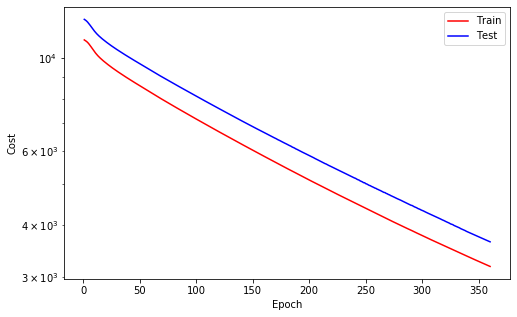



Epoch   361
Train_cost  = 3174.4311 | Test_cost  = 3634.9209 | 




Epoch   362
Train_cost  = 3165.6620 | Test_cost  = 3624.4661 | 




Epoch   363
Train_cost  = 3156.6950 | Test_cost  = 3615.0332 | 




Epoch   364
Train_cost  = 3148.0610 | Test_cost  = 3603.7461 | 




Epoch   365
Train_cost  = 3139.6043 | Test_cost  = 3594.1968 | 




Epoch   366
Train_cost  = 3130.8752 | Test_cost  = 3587.5244 | 




Epoch   367
Train_cost  = 3122.5304 | Test_cost  = 3574.6323 | 




Epoch   368
Train_cost  = 3114.1417 | Test_cost  = 3565.5527 | 




Epoch   369
Train_cost  = 3106.6179 | Test_cost  = 3556.4702 | 




Epoch   370
Train_cost  = 3098.1760 | Test_cost  = 3550.8496 | 




Epoch   371
Train_cost  = 3090.4229 | Test_cost  = 3537.2056 | 




Epoch   372
Train_cost  = 3082.6355 | Test_cost  = 3527.3086 | 




Epoch   373
Train_cost  = 3075.8818 | Test_cost  = 3518.3218 | 




Epoch   374
Train_cost  = 3066.3237 | Test_cost  = 3508.2639 | 




Epoch   375
Train_cost  = 3059.7936 | Test_cost  = 3497.3130 | 




Epoch   376
Train_cost  = 3051.6948 | Test_cost  = 3486.5459 | 




Epoch   377
Train_cost  = 3042.9393 | Test_cost  = 3477.2651 | 




Epoch   378
Train_cost  = 3034.0979 | Test_cost  = 3463.5850 | 




Epoch   379
Train_cost  = 3025.5141 | Test_cost  = 3459.6917 | 




Epoch   380
Train_cost  = 3017.0629 | Test_cost  = 3445.6763 | 


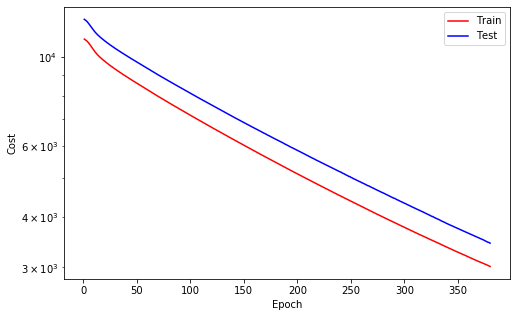



Epoch   381
Train_cost  = 3008.5064 | Test_cost  = 3437.5032 | 




Epoch   382
Train_cost  = 3000.1474 | Test_cost  = 3430.7593 | 




Epoch   383
Train_cost  = 2991.7155 | Test_cost  = 3418.5012 | 




Epoch   384
Train_cost  = 2983.5970 | Test_cost  = 3411.7134 | 




Epoch   385
Train_cost  = 2975.7399 | Test_cost  = 3398.7983 | 




Epoch   386
Train_cost  = 2967.8140 | Test_cost  = 3392.9561 | 




Epoch   387
Train_cost  = 2959.7082 | Test_cost  = 3383.4407 | 




Epoch   388
Train_cost  = 2951.6346 | Test_cost  = 3373.5305 | 




Epoch   389
Train_cost  = 2943.8767 | Test_cost  = 3366.1177 | 




Epoch   390
Train_cost  = 2936.2772 | Test_cost  = 3354.0957 | 




Epoch   391
Train_cost  = 2928.6470 | Test_cost  = 3350.1504 | 




Epoch   392
Train_cost  = 2920.9998 | Test_cost  = 3338.0186 | 




Epoch   393
Train_cost  = 2913.5233 | Test_cost  = 3330.2222 | 




Epoch   394
Train_cost  = 2905.7494 | Test_cost  = 3323.2891 | 




Epoch   395
Train_cost  = 2898.1616 | Test_cost  = 3310.5710 | 




Epoch   396
Train_cost  = 2890.7932 | Test_cost  = 3304.9216 | 




Epoch   397
Train_cost  = 2882.8244 | Test_cost  = 3296.0317 | 




Epoch   398
Train_cost  = 2875.4642 | Test_cost  = 3286.2239 | 




Epoch   399
Train_cost  = 2868.2976 | Test_cost  = 3278.2253 | 




Epoch   400
Train_cost  = 2860.6067 | Test_cost  = 3267.3232 | 


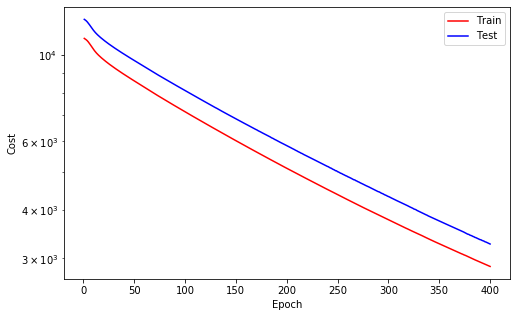



Epoch   401
Train_cost  = 2853.0221 | Test_cost  = 3262.9714 | 




Epoch   402
Train_cost  = 2846.0191 | Test_cost  = 3252.0972 | 




Epoch   403
Train_cost  = 2839.1017 | Test_cost  = 3241.6218 | 




Epoch   404
Train_cost  = 2831.3370 | Test_cost  = 3239.3337 | 




Epoch   405
Train_cost  = 2825.0476 | Test_cost  = 3227.7651 | 




Epoch   406
Train_cost  = 2817.5480 | Test_cost  = 3217.0151 | 




Epoch   407
Train_cost  = 2811.7769 | Test_cost  = 3214.1926 | 




Epoch   408
Train_cost  = 2805.3457 | Test_cost  = 3200.1218 | 




Epoch   409
Train_cost  = 2797.5581 | Test_cost  = 3190.7285 | 




Epoch   410
Train_cost  = 2791.1856 | Test_cost  = 3190.1511 | 




Epoch   411
Train_cost  = 2785.2866 | Test_cost  = 3174.9927 | 




Epoch   412
Train_cost  = 2776.7133 | Test_cost  = 3164.2202 | 




Epoch   413
Train_cost  = 2769.9400 | Test_cost  = 3163.2522 | 




Epoch   414
Train_cost  = 2763.1171 | Test_cost  = 3146.8843 | 




Epoch   415
Train_cost  = 2754.0871 | Test_cost  = 3138.1072 | 




Epoch   416
Train_cost  = 2747.2429 | Test_cost  = 3134.2590 | 




Epoch   417
Train_cost  = 2740.3638 | Test_cost  = 3117.6282 | 




Epoch   418
Train_cost  = 2732.8568 | Test_cost  = 3117.2375 | 




Epoch   419
Train_cost  = 2726.1173 | Test_cost  = 3105.6780 | 




Epoch   420
Train_cost  = 2718.5498 | Test_cost  = 3097.9441 | 


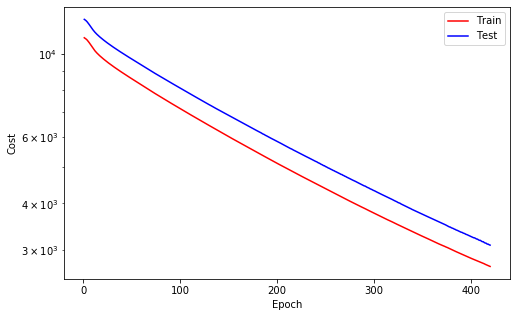



Epoch   421
Train_cost  = 2711.7645 | Test_cost  = 3092.2471 | 




Epoch   422
Train_cost  = 2704.8532 | Test_cost  = 3077.2627 | 




Epoch   423
Train_cost  = 2698.7189 | Test_cost  = 3080.5344 | 
==> EarlyStop patience =  1 | Best test_cost: 3077.2627




Epoch   424
Train_cost  = 2692.8203 | Test_cost  = 3066.9587 | 




Epoch   425
Train_cost  = 2685.2542 | Test_cost  = 3058.5347 | 




Epoch   426
Train_cost  = 2678.8006 | Test_cost  = 3055.2649 | 




Epoch   427
Train_cost  = 2672.4868 | Test_cost  = 3038.3669 | 




Epoch   428
Train_cost  = 2665.5714 | Test_cost  = 3039.3140 | 
==> EarlyStop patience =  1 | Best test_cost: 3038.3669




Epoch   429
Train_cost  = 2659.1954 | Test_cost  = 3026.2329 | 




Epoch   430
Train_cost  = 2651.7441 | Test_cost  = 3019.5740 | 




Epoch   431
Train_cost  = 2645.4772 | Test_cost  = 3011.6660 | 




Epoch   432
Train_cost  = 2638.2442 | Test_cost  = 3000.3706 | 




Epoch   433
Train_cost  = 2632.9246 | Test_cost  = 3000.1648 | 




Epoch   434
Train_cost  = 2626.6399 | Test_cost  = 2985.8000 | 




Epoch   435
Train_cost  = 2619.0799 | Test_cost  = 2983.8079 | 




Epoch   436
Train_cost  = 2612.9657 | Test_cost  = 2973.5310 | 




Epoch   437
Train_cost  = 2606.7692 | Test_cost  = 2962.9417 | 




Epoch   438
Train_cost  = 2600.8894 | Test_cost  = 2962.1614 | 




Epoch   439
Train_cost  = 2594.3016 | Test_cost  = 2946.7205 | 




Epoch   440
Train_cost  = 2587.9600 | Test_cost  = 2947.4531 | 


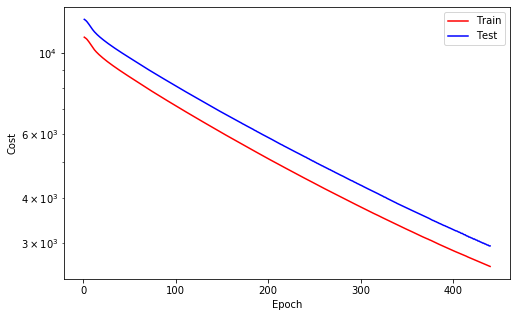

==> EarlyStop patience =  1 | Best test_cost: 2946.7205




Epoch   441
Train_cost  = 2581.4315 | Test_cost  = 2932.6047 | 




Epoch   442
Train_cost  = 2574.2911 | Test_cost  = 2928.9333 | 




Epoch   443
Train_cost  = 2568.6025 | Test_cost  = 2918.0178 | 




Epoch   444
Train_cost  = 2561.7403 | Test_cost  = 2909.6807 | 




Epoch   445
Train_cost  = 2555.9338 | Test_cost  = 2906.0071 | 




Epoch   446
Train_cost  = 2549.3296 | Test_cost  = 2895.5713 | 




Epoch   447
Train_cost  = 2542.6533 | Test_cost  = 2891.5620 | 




Epoch   448
Train_cost  = 2536.3510 | Test_cost  = 2881.8206 | 




Epoch   449
Train_cost  = 2529.7500 | Test_cost  = 2876.2441 | 




Epoch   450
Train_cost  = 2523.6298 | Test_cost  = 2870.2766 | 




Epoch   451
Train_cost  = 2517.8807 | Test_cost  = 2859.2625 | 




Epoch   452
Train_cost  = 2511.7734 | Test_cost  = 2855.1804 | 




Epoch   453
Train_cost  = 2506.7805 | Test_cost  = 2848.3298 | 




Epoch   454
Train_cost  = 2502.3022 | Test_cost  = 2837.9187 | 




Epoch   455
Train_cost  = 2496.2915 | Test_cost  = 2838.3999 | 
==> EarlyStop patience =  1 | Best test_cost: 2837.9187




Epoch   456
Train_cost  = 2490.8229 | Test_cost  = 2821.2083 | 




Epoch   457
Train_cost  = 2486.2393 | Test_cost  = 2824.5032 | 
==> EarlyStop patience =  1 | Best test_cost: 2821.2083




Epoch   458
Train_cost  = 2480.4448 | Test_cost  = 2805.2371 | 




Epoch   459
Train_cost  = 2477.3605 | Test_cost  = 2807.2695 | 
==> EarlyStop patience =  1 | Best test_cost: 2805.2371




Epoch   460
Train_cost  = 2469.9021 | Test_cost  = 2792.1162 | 


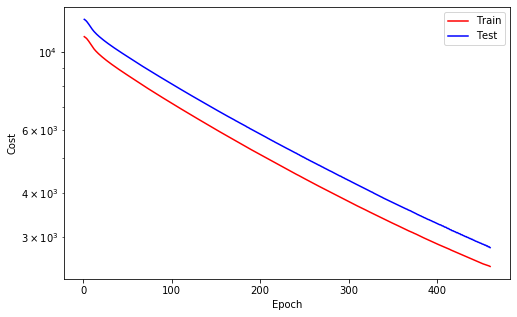



Epoch   461
Train_cost  = 2462.8478 | Test_cost  = 2784.9795 | 




Epoch   462
Train_cost  = 2456.5811 | Test_cost  = 2785.3582 | 
==> EarlyStop patience =  1 | Best test_cost: 2784.9795




Epoch   463
Train_cost  = 2449.2521 | Test_cost  = 2773.1707 | 




Epoch   464
Train_cost  = 2444.8589 | Test_cost  = 2768.7354 | 




Epoch   465
Train_cost  = 2437.7456 | Test_cost  = 2759.9746 | 




Epoch   466
Train_cost  = 2430.4203 | Test_cost  = 2752.6504 | 




Epoch   467
Train_cost  = 2424.7321 | Test_cost  = 2744.9583 | 




Epoch   468
Train_cost  = 2418.6200 | Test_cost  = 2737.9797 | 




Epoch   469
Train_cost  = 2413.2064 | Test_cost  = 2731.2576 | 




Epoch   470
Train_cost  = 2408.2587 | Test_cost  = 2727.6196 | 




Epoch   471
Train_cost  = 2404.2742 | Test_cost  = 2715.5234 | 




Epoch   472
Train_cost  = 2399.9758 | Test_cost  = 2712.7515 | 




Epoch   473
Train_cost  = 2394.0320 | Test_cost  = 2703.2612 | 




Epoch   474
Train_cost  = 2389.1385 | Test_cost  = 2694.1050 | 




Epoch   475
Train_cost  = 2382.1332 | Test_cost  = 2691.9878 | 




Epoch   476
Train_cost  = 2375.8268 | Test_cost  = 2682.9067 | 




Epoch   477
Train_cost  = 2369.0063 | Test_cost  = 2677.4661 | 




Epoch   478
Train_cost  = 2363.6655 | Test_cost  = 2666.8782 | 




Epoch   479
Train_cost  = 2357.2549 | Test_cost  = 2660.4199 | 




Epoch   480
Train_cost  = 2351.4574 | Test_cost  = 2654.7979 | 


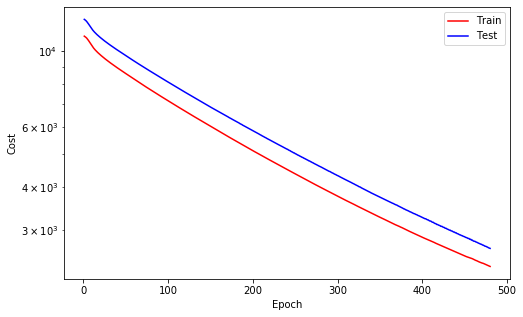



Epoch   481
Train_cost  = 2345.9497 | Test_cost  = 2649.6729 | 




Epoch   482
Train_cost  = 2340.6791 | Test_cost  = 2642.3860 | 




Epoch   483
Train_cost  = 2335.2180 | Test_cost  = 2638.4026 | 




Epoch   484
Train_cost  = 2329.3995 | Test_cost  = 2629.5476 | 




Epoch   485
Train_cost  = 2324.1840 | Test_cost  = 2625.0559 | 




Epoch   486
Train_cost  = 2319.0023 | Test_cost  = 2619.0476 | 




Epoch   487
Train_cost  = 2313.8870 | Test_cost  = 2610.3557 | 




Epoch   488
Train_cost  = 2308.9627 | Test_cost  = 2608.3569 | 




Epoch   489
Train_cost  = 2304.7285 | Test_cost  = 2595.8289 | 




Epoch   490
Train_cost  = 2300.2859 | Test_cost  = 2594.0969 | 




Epoch   491
Train_cost  = 2294.3551 | Test_cost  = 2583.2275 | 




Epoch   492
Train_cost  = 2289.1941 | Test_cost  = 2581.9302 | 




Epoch   493
Train_cost  = 2282.1588 | Test_cost  = 2574.4148 | 




Epoch   494
Train_cost  = 2276.8969 | Test_cost  = 2566.7034 | 




Epoch   495
Train_cost  = 2270.5319 | Test_cost  = 2564.9224 | 




Epoch   496
Train_cost  = 2265.8646 | Test_cost  = 2551.7639 | 




Epoch   497
Train_cost  = 2260.1594 | Test_cost  = 2554.6326 | 
==> EarlyStop patience =  1 | Best test_cost: 2551.7639




Epoch   498
Train_cost  = 2255.3998 | Test_cost  = 2538.0913 | 




Epoch   499
Train_cost  = 2250.0324 | Test_cost  = 2544.3694 | 
==> EarlyStop patience =  1 | Best test_cost: 2538.0913




Epoch   500
Train_cost  = 2245.0452 | Test_cost  = 2527.3176 | 


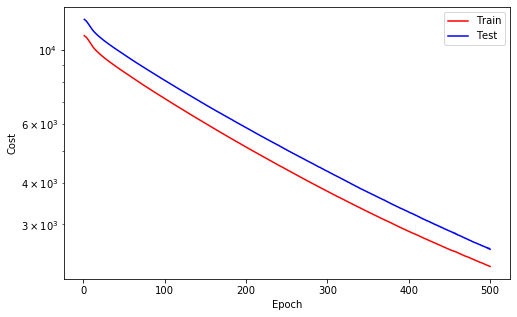



Epoch   501
Train_cost  = 2239.8020 | Test_cost  = 2530.5862 | 
==> EarlyStop patience =  1 | Best test_cost: 2527.3176




Epoch   502
Train_cost  = 2234.4568 | Test_cost  = 2519.0088 | 




Epoch   503
Train_cost  = 2229.4744 | Test_cost  = 2513.7520 | 




Epoch   504
Train_cost  = 2224.6813 | Test_cost  = 2511.3164 | 




Epoch   505
Train_cost  = 2219.5238 | Test_cost  = 2498.2444 | 




Epoch   506
Train_cost  = 2214.1453 | Test_cost  = 2502.2937 | 
==> EarlyStop patience =  1 | Best test_cost: 2498.2444




Epoch   507
Train_cost  = 2209.8993 | Test_cost  = 2485.8083 | 




Epoch   508
Train_cost  = 2204.5955 | Test_cost  = 2488.4016 | 
==> EarlyStop patience =  1 | Best test_cost: 2485.8083




Epoch   509
Train_cost  = 2200.0722 | Test_cost  = 2477.0674 | 




Epoch   510
Train_cost  = 2194.6588 | Test_cost  = 2475.5430 | 




Epoch   511
Train_cost  = 2190.1135 | Test_cost  = 2467.3293 | 




Epoch   512
Train_cost  = 2184.7008 | Test_cost  = 2465.8506 | 




Epoch   513
Train_cost  = 2180.5601 | Test_cost  = 2451.3066 | 




Epoch   514
Train_cost  = 2176.2171 | Test_cost  = 2455.7026 | 
==> EarlyStop patience =  1 | Best test_cost: 2451.3066




Epoch   515
Train_cost  = 2170.4901 | Test_cost  = 2442.6199 | 




Epoch   516
Train_cost  = 2165.5295 | Test_cost  = 2438.8901 | 




Epoch   517
Train_cost  = 2160.4788 | Test_cost  = 2435.2329 | 




Epoch   518
Train_cost  = 2154.2903 | Test_cost  = 2425.1816 | 




Epoch   519
Train_cost  = 2148.9787 | Test_cost  = 2420.6208 | 




Epoch   520
Train_cost  = 2144.5507 | Test_cost  = 2411.9937 | 


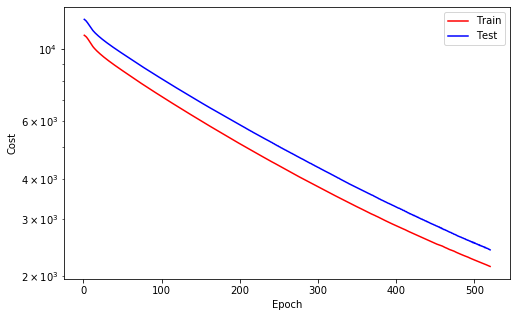



Epoch   521
Train_cost  = 2139.2378 | Test_cost  = 2413.6289 | 
==> EarlyStop patience =  1 | Best test_cost: 2411.9937




Epoch   522
Train_cost  = 2134.9347 | Test_cost  = 2402.0557 | 




Epoch   523
Train_cost  = 2129.8865 | Test_cost  = 2401.1526 | 




Epoch   524
Train_cost  = 2124.1841 | Test_cost  = 2392.8557 | 




Epoch   525
Train_cost  = 2119.4572 | Test_cost  = 2385.3296 | 




Epoch   526
Train_cost  = 2114.7577 | Test_cost  = 2382.2881 | 




Epoch   527
Train_cost  = 2110.2830 | Test_cost  = 2380.1833 | 




Epoch   528
Train_cost  = 2106.5317 | Test_cost  = 2368.4031 | 




Epoch   529
Train_cost  = 2102.2359 | Test_cost  = 2369.8484 | 
==> EarlyStop patience =  1 | Best test_cost: 2368.4031




Epoch   530
Train_cost  = 2097.1587 | Test_cost  = 2363.7615 | 




Epoch   531
Train_cost  = 2092.4601 | Test_cost  = 2355.2043 | 




Epoch   532
Train_cost  = 2088.5250 | Test_cost  = 2352.6340 | 




Epoch   533
Train_cost  = 2083.5970 | Test_cost  = 2353.4673 | 
==> EarlyStop patience =  1 | Best test_cost: 2352.6340




Epoch   534
Train_cost  = 2082.3230 | Test_cost  = 2337.6370 | 




Epoch   535
Train_cost  = 2075.8712 | Test_cost  = 2334.8398 | 




Epoch   536
Train_cost  = 2069.4267 | Test_cost  = 2328.9585 | 




Epoch   537
Train_cost  = 2064.6099 | Test_cost  = 2323.4180 | 




Epoch   538
Train_cost  = 2060.3242 | Test_cost  = 2316.3428 | 




Epoch   539
Train_cost  = 2055.8847 | Test_cost  = 2320.1094 | 
==> EarlyStop patience =  1 | Best test_cost: 2316.3428




Epoch   540
Train_cost  = 2053.7532 | Test_cost  = 2302.0454 | 


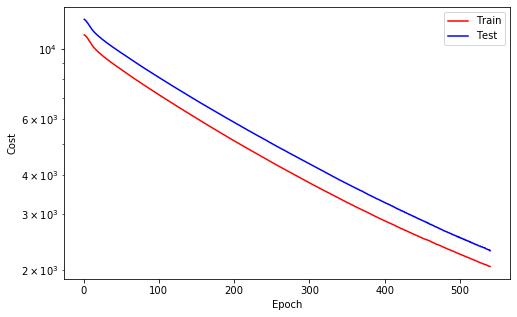



Epoch   541
Train_cost  = 2048.8048 | Test_cost  = 2310.9910 | 
==> EarlyStop patience =  1 | Best test_cost: 2302.0454




Epoch   542
Train_cost  = 2046.1363 | Test_cost  = 2293.4353 | 




Epoch   543
Train_cost  = 2040.6669 | Test_cost  = 2290.4653 | 




Epoch   544
Train_cost  = 2036.3292 | Test_cost  = 2294.7380 | 
==> EarlyStop patience =  1 | Best test_cost: 2290.4653




Epoch   545
Train_cost  = 2032.7056 | Test_cost  = 2275.2603 | 




Epoch   546
Train_cost  = 2026.5285 | Test_cost  = 2272.6274 | 




Epoch   547
Train_cost  = 2021.9806 | Test_cost  = 2277.9165 | 
==> EarlyStop patience =  1 | Best test_cost: 2272.6274




Epoch   548
Train_cost  = 2018.2940 | Test_cost  = 2262.6641 | 




Epoch   549
Train_cost  = 2012.6724 | Test_cost  = 2268.5381 | 
==> EarlyStop patience =  1 | Best test_cost: 2262.6641




Epoch   550
Train_cost  = 2011.4681 | Test_cost  = 2251.8938 | 




Epoch   551
Train_cost  = 2004.4407 | Test_cost  = 2250.6658 | 




Epoch   552
Train_cost  = 1999.2763 | Test_cost  = 2240.7136 | 




Epoch   553
Train_cost  = 1995.6791 | Test_cost  = 2237.6682 | 




Epoch   554
Train_cost  = 1990.7379 | Test_cost  = 2239.5417 | 
==> EarlyStop patience =  1 | Best test_cost: 2237.6682




Epoch   555
Train_cost  = 1989.7560 | Test_cost  = 2219.9600 | 




Epoch   556
Train_cost  = 1984.3862 | Test_cost  = 2229.2671 | 
==> EarlyStop patience =  1 | Best test_cost: 2219.9600




Epoch   557
Train_cost  = 1979.6528 | Test_cost  = 2211.5840 | 




Epoch   558
Train_cost  = 1974.2653 | Test_cost  = 2219.1077 | 
==> EarlyStop patience =  1 | Best test_cost: 2211.5840




Epoch   559
Train_cost  = 1970.6014 | Test_cost  = 2210.8613 | 




Epoch   560
Train_cost  = 1968.5510 | Test_cost  = 2199.2090 | 


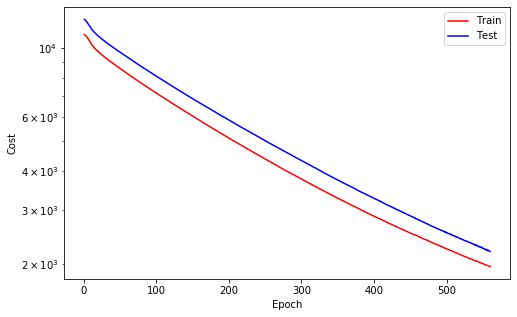



Epoch   561
Train_cost  = 1967.9595 | Test_cost  = 2200.4895 | 
==> EarlyStop patience =  1 | Best test_cost: 2199.2090




Epoch   562
Train_cost  = 1962.4624 | Test_cost  = 2182.3818 | 




Epoch   563
Train_cost  = 1958.1760 | Test_cost  = 2198.6521 | 
==> EarlyStop patience =  1 | Best test_cost: 2182.3818




Epoch   564
Train_cost  = 1953.1217 | Test_cost  = 2178.4634 | 




Epoch   565
Train_cost  = 1947.6886 | Test_cost  = 2183.0664 | 
==> EarlyStop patience =  1 | Best test_cost: 2178.4634




Epoch   566
Train_cost  = 1943.3948 | Test_cost  = 2167.4392 | 




Epoch   567
Train_cost  = 1940.5429 | Test_cost  = 2158.0344 | 




Epoch   568
Train_cost  = 1934.9505 | Test_cost  = 2168.4868 | 
==> EarlyStop patience =  1 | Best test_cost: 2158.0344




Epoch   569
Train_cost  = 1929.8146 | Test_cost  = 2150.8835 | 




Epoch   570
Train_cost  = 1924.5886 | Test_cost  = 2159.1282 | 
==> EarlyStop patience =  1 | Best test_cost: 2150.8835




Epoch   571
Train_cost  = 1920.7080 | Test_cost  = 2141.9644 | 




Epoch   572
Train_cost  = 1914.9442 | Test_cost  = 2140.3176 | 




Epoch   573
Train_cost  = 1909.2578 | Test_cost  = 2136.5024 | 




Epoch   574
Train_cost  = 1904.0054 | Test_cost  = 2128.5991 | 




Epoch   575
Train_cost  = 1899.5812 | Test_cost  = 2133.0847 | 
==> EarlyStop patience =  1 | Best test_cost: 2128.5991




Epoch   576
Train_cost  = 1896.1490 | Test_cost  = 2119.7551 | 




Epoch   577
Train_cost  = 1891.8233 | Test_cost  = 2119.2791 | 




Epoch   578
Train_cost  = 1888.0062 | Test_cost  = 2115.9219 | 




Epoch   579
Train_cost  = 1885.5331 | Test_cost  = 2106.8643 | 




Epoch   580
Train_cost  = 1880.6925 | Test_cost  = 2109.5286 | 


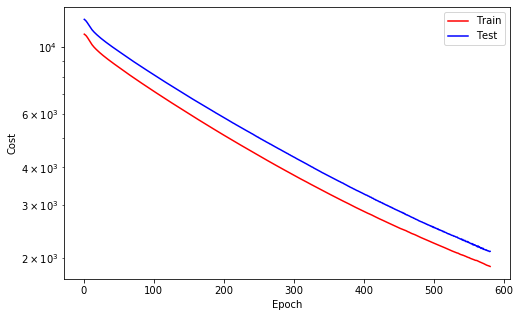

==> EarlyStop patience =  1 | Best test_cost: 2106.8643




Epoch   581
Train_cost  = 1878.4106 | Test_cost  = 2094.8503 | 




Epoch   582
Train_cost  = 1873.0685 | Test_cost  = 2097.7063 | 
==> EarlyStop patience =  1 | Best test_cost: 2094.8503




Epoch   583
Train_cost  = 1868.2095 | Test_cost  = 2088.7754 | 




Epoch   584
Train_cost  = 1864.6995 | Test_cost  = 2084.9944 | 




Epoch   585
Train_cost  = 1861.6837 | Test_cost  = 2088.0500 | 
==> EarlyStop patience =  1 | Best test_cost: 2084.9944




Epoch   586
Train_cost  = 1860.1211 | Test_cost  = 2071.6482 | 




Epoch   587
Train_cost  = 1854.1496 | Test_cost  = 2080.2966 | 
==> EarlyStop patience =  1 | Best test_cost: 2071.6482




Epoch   588
Train_cost  = 1851.8554 | Test_cost  = 2063.5425 | 




Epoch   589
Train_cost  = 1846.8420 | Test_cost  = 2064.6694 | 
==> EarlyStop patience =  1 | Best test_cost: 2063.5425




Epoch   590
Train_cost  = 1842.5850 | Test_cost  = 2061.8010 | 




Epoch   591
Train_cost  = 1840.2552 | Test_cost  = 2047.4827 | 




Epoch   592
Train_cost  = 1836.9931 | Test_cost  = 2057.9236 | 
==> EarlyStop patience =  1 | Best test_cost: 2047.4827




Epoch   593
Train_cost  = 1835.7618 | Test_cost  = 2037.9664 | 




Epoch   594
Train_cost  = 1828.7297 | Test_cost  = 2048.6741 | 
==> EarlyStop patience =  1 | Best test_cost: 2037.9664




Epoch   595
Train_cost  = 1825.0015 | Test_cost  = 2034.5162 | 




Epoch   596
Train_cost  = 1822.9029 | Test_cost  = 2024.9937 | 




Epoch   597
Train_cost  = 1819.4680 | Test_cost  = 2035.2982 | 
==> EarlyStop patience =  1 | Best test_cost: 2024.9937




Epoch   598
Train_cost  = 1816.1025 | Test_cost  = 2016.1855 | 




Epoch   599
Train_cost  = 1811.3176 | Test_cost  = 2029.7828 | 
==> EarlyStop patience =  1 | Best test_cost: 2016.1855




Epoch   600
Train_cost  = 1809.3104 | Test_cost  = 2008.2042 | 


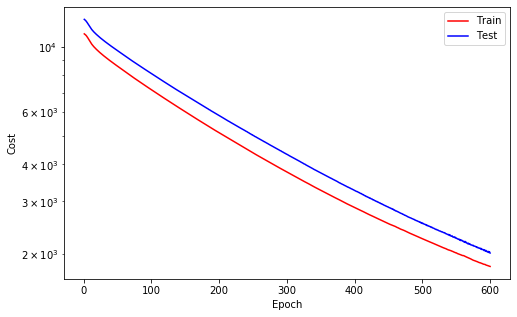



Epoch   601
Train_cost  = 1802.1933 | Test_cost  = 2011.0000 | 
==> EarlyStop patience =  1 | Best test_cost: 2008.2042




Epoch   602
Train_cost  = 1798.8912 | Test_cost  = 2000.6556 | 




Epoch   603
Train_cost  = 1792.8145 | Test_cost  = 1997.5671 | 




Epoch   604
Train_cost  = 1788.0091 | Test_cost  = 1997.1133 | 




Epoch   605
Train_cost  = 1784.0870 | Test_cost  = 1985.6078 | 




Epoch   606
Train_cost  = 1780.0963 | Test_cost  = 1991.4758 | 
==> EarlyStop patience =  1 | Best test_cost: 1985.6078




Epoch   607
Train_cost  = 1777.1112 | Test_cost  = 1976.7433 | 




Epoch   608
Train_cost  = 1773.0200 | Test_cost  = 1980.8225 | 
==> EarlyStop patience =  1 | Best test_cost: 1976.7433




Epoch   609
Train_cost  = 1769.8149 | Test_cost  = 1973.7258 | 




Epoch   610
Train_cost  = 1767.3268 | Test_cost  = 1966.7826 | 




Epoch   611
Train_cost  = 1764.0741 | Test_cost  = 1973.2327 | 
==> EarlyStop patience =  1 | Best test_cost: 1966.7826




Epoch   612
Train_cost  = 1763.6504 | Test_cost  = 1954.6018 | 




Epoch   613
Train_cost  = 1757.7995 | Test_cost  = 1964.5792 | 
==> EarlyStop patience =  1 | Best test_cost: 1954.6018




Epoch   614
Train_cost  = 1755.0947 | Test_cost  = 1946.2080 | 




Epoch   615
Train_cost  = 1749.6864 | Test_cost  = 1951.2915 | 
==> EarlyStop patience =  1 | Best test_cost: 1946.2080




Epoch   616
Train_cost  = 1745.9401 | Test_cost  = 1944.2521 | 




Epoch   617
Train_cost  = 1742.6703 | Test_cost  = 1935.8711 | 




Epoch   618
Train_cost  = 1739.1336 | Test_cost  = 1944.0283 | 
==> EarlyStop patience =  1 | Best test_cost: 1935.8711




Epoch   619
Train_cost  = 1738.3923 | Test_cost  = 1924.4893 | 




Epoch   620
Train_cost  = 1732.5863 | Test_cost  = 1936.2102 | 


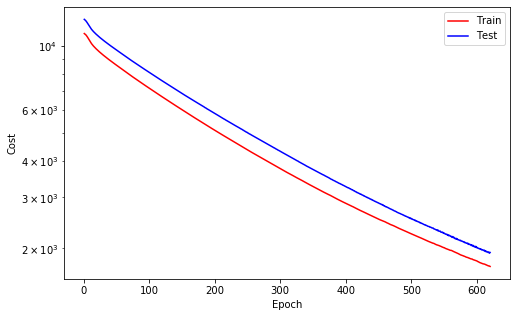

==> EarlyStop patience =  1 | Best test_cost: 1924.4893




Epoch   621
Train_cost  = 1730.1947 | Test_cost  = 1916.4601 | 




Epoch   622
Train_cost  = 1725.0856 | Test_cost  = 1921.9401 | 
==> EarlyStop patience =  1 | Best test_cost: 1916.4601




Epoch   623
Train_cost  = 1721.1415 | Test_cost  = 1915.0945 | 




Epoch   624
Train_cost  = 1717.8565 | Test_cost  = 1905.7089 | 




Epoch   625
Train_cost  = 1713.5002 | Test_cost  = 1915.3385 | 
==> EarlyStop patience =  1 | Best test_cost: 1905.7089




Epoch   626
Train_cost  = 1713.2406 | Test_cost  = 1894.9730 | 




Epoch   627
Train_cost  = 1707.7271 | Test_cost  = 1907.1979 | 
==> EarlyStop patience =  1 | Best test_cost: 1894.9730




Epoch   628
Train_cost  = 1706.0269 | Test_cost  = 1887.6344 | 




Epoch   629
Train_cost  = 1700.6492 | Test_cost  = 1895.2526 | 
==> EarlyStop patience =  1 | Best test_cost: 1887.6344




Epoch   630
Train_cost  = 1696.2209 | Test_cost  = 1885.3870 | 




Epoch   631
Train_cost  = 1692.3522 | Test_cost  = 1877.9216 | 




Epoch   632
Train_cost  = 1688.2504 | Test_cost  = 1884.8344 | 
==> EarlyStop patience =  1 | Best test_cost: 1877.9216




Epoch   633
Train_cost  = 1686.6996 | Test_cost  = 1867.9115 | 




Epoch   634
Train_cost  = 1682.1464 | Test_cost  = 1877.8816 | 
==> EarlyStop patience =  1 | Best test_cost: 1867.9115




Epoch   635
Train_cost  = 1679.7835 | Test_cost  = 1860.1877 | 




Epoch   636
Train_cost  = 1675.6698 | Test_cost  = 1864.9078 | 
==> EarlyStop patience =  1 | Best test_cost: 1860.1877




Epoch   637
Train_cost  = 1671.5763 | Test_cost  = 1861.1055 | 
==> EarlyStop patience =  2 | Best test_cost: 1860.1877




Epoch   638
Train_cost  = 1669.1184 | Test_cost  = 1848.7822 | 




Epoch   639
Train_cost  = 1665.5081 | Test_cost  = 1859.9395 | 
==> EarlyStop patience =  1 | Best test_cost: 1848.7822




Epoch   640
Train_cost  = 1665.1155 | Test_cost  = 1838.4161 | 


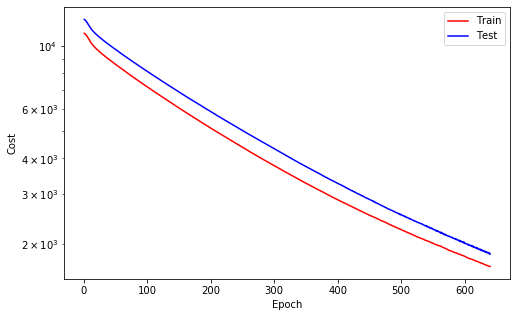



Epoch   641
Train_cost  = 1659.9056 | Test_cost  = 1851.5702 | 
==> EarlyStop patience =  1 | Best test_cost: 1838.4161




Epoch   642
Train_cost  = 1657.0253 | Test_cost  = 1833.6250 | 




Epoch   643
Train_cost  = 1652.8698 | Test_cost  = 1838.4309 | 
==> EarlyStop patience =  1 | Best test_cost: 1833.6250




Epoch   644
Train_cost  = 1649.3765 | Test_cost  = 1834.1224 | 
==> EarlyStop patience =  2 | Best test_cost: 1833.6250




Epoch   645
Train_cost  = 1647.2655 | Test_cost  = 1821.2091 | 




Epoch   646
Train_cost  = 1643.2381 | Test_cost  = 1833.4272 | 
==> EarlyStop patience =  1 | Best test_cost: 1821.2091




Epoch   647
Train_cost  = 1642.6979 | Test_cost  = 1811.4005 | 




Epoch   648
Train_cost  = 1637.5773 | Test_cost  = 1824.1964 | 
==> EarlyStop patience =  1 | Best test_cost: 1811.4005




Epoch   649
Train_cost  = 1635.6687 | Test_cost  = 1805.1379 | 




Epoch   650
Train_cost  = 1630.8466 | Test_cost  = 1809.2490 | 
==> EarlyStop patience =  1 | Best test_cost: 1805.1379




Epoch   651
Train_cost  = 1626.1494 | Test_cost  = 1805.8826 | 
==> EarlyStop patience =  2 | Best test_cost: 1805.1379




Epoch   652
Train_cost  = 1623.3325 | Test_cost  = 1793.6622 | 




Epoch   653
Train_cost  = 1620.9827 | Test_cost  = 1804.0652 | 
==> EarlyStop patience =  1 | Best test_cost: 1793.6622




Epoch   654
Train_cost  = 1620.2288 | Test_cost  = 1783.9432 | 




Epoch   655
Train_cost  = 1616.5671 | Test_cost  = 1799.6808 | 
==> EarlyStop patience =  1 | Best test_cost: 1783.9432




Epoch   656
Train_cost  = 1616.9442 | Test_cost  = 1780.0765 | 




Epoch   657
Train_cost  = 1609.6503 | Test_cost  = 1786.0785 | 
==> EarlyStop patience =  1 | Best test_cost: 1780.0765




Epoch   658
Train_cost  = 1605.0650 | Test_cost  = 1773.1250 | 




Epoch   659
Train_cost  = 1600.4407 | Test_cost  = 1772.2902 | 




Epoch   660
Train_cost  = 1596.5907 | Test_cost  = 1769.7626 | 


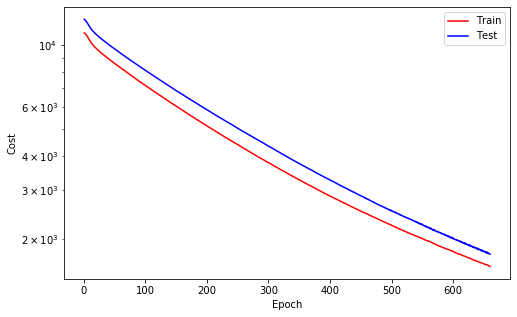



Epoch   661
Train_cost  = 1593.3573 | Test_cost  = 1759.9159 | 




Epoch   662
Train_cost  = 1590.7212 | Test_cost  = 1764.0499 | 
==> EarlyStop patience =  1 | Best test_cost: 1759.9159




Epoch   663
Train_cost  = 1587.6107 | Test_cost  = 1753.4594 | 




Epoch   664
Train_cost  = 1584.7334 | Test_cost  = 1760.1676 | 
==> EarlyStop patience =  1 | Best test_cost: 1753.4594




Epoch   665
Train_cost  = 1582.7437 | Test_cost  = 1744.2057 | 




Epoch   666
Train_cost  = 1578.3813 | Test_cost  = 1751.8441 | 
==> EarlyStop patience =  1 | Best test_cost: 1744.2057




Epoch   667
Train_cost  = 1575.1210 | Test_cost  = 1740.9176 | 




Epoch   668
Train_cost  = 1573.8611 | Test_cost  = 1740.4263 | 




Epoch   669
Train_cost  = 1570.8990 | Test_cost  = 1742.9481 | 
==> EarlyStop patience =  1 | Best test_cost: 1740.4263




Epoch   670
Train_cost  = 1569.1788 | Test_cost  = 1726.8729 | 




Epoch   671
Train_cost  = 1567.4259 | Test_cost  = 1742.3796 | 
==> EarlyStop patience =  1 | Best test_cost: 1726.8729




Epoch   672
Train_cost  = 1567.2983 | Test_cost  = 1723.4814 | 




Epoch   673
Train_cost  = 1560.2691 | Test_cost  = 1729.9701 | 
==> EarlyStop patience =  1 | Best test_cost: 1723.4814




Epoch   674
Train_cost  = 1557.8027 | Test_cost  = 1714.7496 | 




Epoch   675
Train_cost  = 1554.0061 | Test_cost  = 1713.7261 | 




Epoch   676
Train_cost  = 1550.2585 | Test_cost  = 1712.2760 | 




Epoch   677
Train_cost  = 1545.5159 | Test_cost  = 1700.3447 | 




Epoch   678
Train_cost  = 1543.3307 | Test_cost  = 1711.6931 | 
==> EarlyStop patience =  1 | Best test_cost: 1700.3447




Epoch   679
Train_cost  = 1542.0069 | Test_cost  = 1695.6775 | 




Epoch   680
Train_cost  = 1537.1088 | Test_cost  = 1699.7710 | 


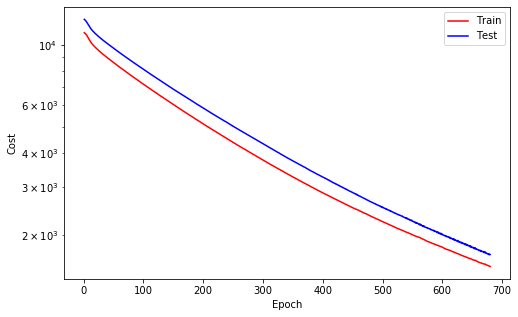

==> EarlyStop patience =  1 | Best test_cost: 1695.6775




Epoch   681
Train_cost  = 1533.4042 | Test_cost  = 1690.8817 | 




Epoch   682
Train_cost  = 1529.9820 | Test_cost  = 1688.8870 | 




Epoch   683
Train_cost  = 1525.8224 | Test_cost  = 1687.3347 | 




Epoch   684
Train_cost  = 1521.9414 | Test_cost  = 1677.5070 | 




Epoch   685
Train_cost  = 1519.4526 | Test_cost  = 1686.2749 | 
==> EarlyStop patience =  1 | Best test_cost: 1677.5070




Epoch   686
Train_cost  = 1517.3426 | Test_cost  = 1671.5581 | 




Epoch   687
Train_cost  = 1514.6651 | Test_cost  = 1676.3048 | 
==> EarlyStop patience =  1 | Best test_cost: 1671.5581




Epoch   688
Train_cost  = 1510.9903 | Test_cost  = 1669.2643 | 




Epoch   689
Train_cost  = 1507.8245 | Test_cost  = 1662.6053 | 




Epoch   690
Train_cost  = 1505.2401 | Test_cost  = 1672.0338 | 
==> EarlyStop patience =  1 | Best test_cost: 1662.6053




Epoch   691
Train_cost  = 1503.7286 | Test_cost  = 1654.6891 | 




Epoch   692
Train_cost  = 1500.1078 | Test_cost  = 1665.2451 | 
==> EarlyStop patience =  1 | Best test_cost: 1654.6891




Epoch   693
Train_cost  = 1497.4247 | Test_cost  = 1650.3118 | 




Epoch   694
Train_cost  = 1495.3167 | Test_cost  = 1648.4285 | 




Epoch   695
Train_cost  = 1491.7477 | Test_cost  = 1654.5525 | 
==> EarlyStop patience =  1 | Best test_cost: 1648.4285




Epoch   696
Train_cost  = 1488.9426 | Test_cost  = 1637.4146 | 




Epoch   697
Train_cost  = 1486.1170 | Test_cost  = 1651.2570 | 
==> EarlyStop patience =  1 | Best test_cost: 1637.4146




Epoch   698
Train_cost  = 1484.6463 | Test_cost  = 1631.7261 | 




Epoch   699
Train_cost  = 1480.5993 | Test_cost  = 1636.0214 | 
==> EarlyStop patience =  1 | Best test_cost: 1631.7261




Epoch   700
Train_cost  = 1476.9815 | Test_cost  = 1633.9575 | 


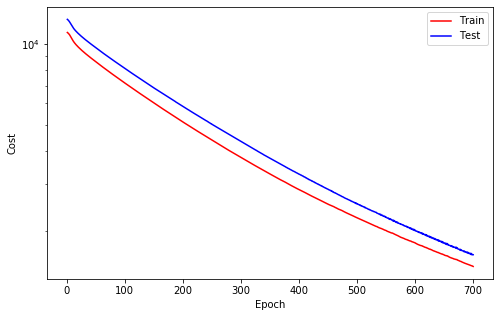

==> EarlyStop patience =  2 | Best test_cost: 1631.7261




Epoch   701
Train_cost  = 1474.3556 | Test_cost  = 1623.2928 | 




Epoch   702
Train_cost  = 1471.4862 | Test_cost  = 1634.5104 | 
==> EarlyStop patience =  1 | Best test_cost: 1623.2928




Epoch   703
Train_cost  = 1470.2100 | Test_cost  = 1614.9855 | 




Epoch   704
Train_cost  = 1465.8485 | Test_cost  = 1627.5085 | 
==> EarlyStop patience =  1 | Best test_cost: 1614.9855




Epoch   705
Train_cost  = 1464.2090 | Test_cost  = 1611.0874 | 




Epoch   706
Train_cost  = 1460.8684 | Test_cost  = 1611.5194 | 
==> EarlyStop patience =  1 | Best test_cost: 1611.0874




Epoch   707
Train_cost  = 1457.0807 | Test_cost  = 1617.8064 | 
==> EarlyStop patience =  2 | Best test_cost: 1611.0874




Epoch   708
Train_cost  = 1454.1970 | Test_cost  = 1598.7209 | 




Epoch   709
Train_cost  = 1451.6416 | Test_cost  = 1614.3020 | 
==> EarlyStop patience =  1 | Best test_cost: 1598.7209




Epoch   710
Train_cost  = 1449.8046 | Test_cost  = 1593.1226 | 




Epoch   711
Train_cost  = 1445.8304 | Test_cost  = 1602.6589 | 
==> EarlyStop patience =  1 | Best test_cost: 1593.1226




Epoch   712
Train_cost  = 1442.1555 | Test_cost  = 1596.5111 | 
==> EarlyStop patience =  2 | Best test_cost: 1593.1226




Epoch   713
Train_cost  = 1439.5395 | Test_cost  = 1588.6793 | 




Epoch   714
Train_cost  = 1436.5197 | Test_cost  = 1599.1302 | 
==> EarlyStop patience =  1 | Best test_cost: 1588.6793




Epoch   715
Train_cost  = 1435.0509 | Test_cost  = 1578.1989 | 




Epoch   716
Train_cost  = 1430.9732 | Test_cost  = 1591.3440 | 
==> EarlyStop patience =  1 | Best test_cost: 1578.1989




Epoch   717
Train_cost  = 1428.8781 | Test_cost  = 1575.3276 | 




Epoch   718
Train_cost  = 1425.9502 | Test_cost  = 1574.5393 | 




Epoch   719
Train_cost  = 1422.5680 | Test_cost  = 1585.0129 | 
==> EarlyStop patience =  1 | Best test_cost: 1574.5393




Epoch   720
Train_cost  = 1420.5310 | Test_cost  = 1563.4735 | 


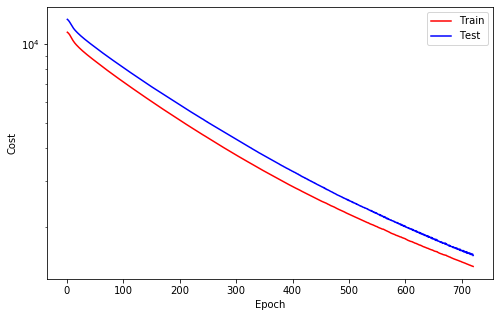



Epoch   721
Train_cost  = 1417.1619 | Test_cost  = 1575.5780 | 
==> EarlyStop patience =  1 | Best test_cost: 1563.4735




Epoch   722
Train_cost  = 1413.9033 | Test_cost  = 1562.0576 | 




Epoch   723
Train_cost  = 1410.1966 | Test_cost  = 1558.1234 | 




Epoch   724
Train_cost  = 1407.5937 | Test_cost  = 1567.8043 | 
==> EarlyStop patience =  1 | Best test_cost: 1558.1234




Epoch   725
Train_cost  = 1405.9990 | Test_cost  = 1551.4948 | 




Epoch   726
Train_cost  = 1402.2839 | Test_cost  = 1554.4980 | 
==> EarlyStop patience =  1 | Best test_cost: 1551.4948




Epoch   727
Train_cost  = 1398.3145 | Test_cost  = 1554.2645 | 
==> EarlyStop patience =  2 | Best test_cost: 1551.4948




Epoch   728
Train_cost  = 1395.7205 | Test_cost  = 1544.3063 | 




Epoch   729
Train_cost  = 1393.1220 | Test_cost  = 1545.6447 | 
==> EarlyStop patience =  1 | Best test_cost: 1544.3063




Epoch   730
Train_cost  = 1389.7190 | Test_cost  = 1550.7511 | 
==> EarlyStop patience =  2 | Best test_cost: 1544.3063




Epoch   731
Train_cost  = 1388.1954 | Test_cost  = 1535.4580 | 




Epoch   732
Train_cost  = 1385.8592 | Test_cost  = 1536.8335 | 
==> EarlyStop patience =  1 | Best test_cost: 1535.4580




Epoch   733
Train_cost  = 1382.5057 | Test_cost  = 1544.1685 | 
==> EarlyStop patience =  2 | Best test_cost: 1535.4580




Epoch   734
Train_cost  = 1382.2873 | Test_cost  = 1530.0378 | 




Epoch   735
Train_cost  = 1378.5374 | Test_cost  = 1528.3824 | 




Epoch   736
Train_cost  = 1374.6143 | Test_cost  = 1535.0367 | 
==> EarlyStop patience =  1 | Best test_cost: 1528.3824




Epoch   737
Train_cost  = 1373.5034 | Test_cost  = 1522.2161 | 




Epoch   738
Train_cost  = 1371.1199 | Test_cost  = 1517.6565 | 




Epoch   739
Train_cost  = 1369.4456 | Test_cost  = 1535.4845 | 
==> EarlyStop patience =  1 | Best test_cost: 1517.6565




Epoch   740
Train_cost  = 1371.1322 | Test_cost  = 1508.9314 | 


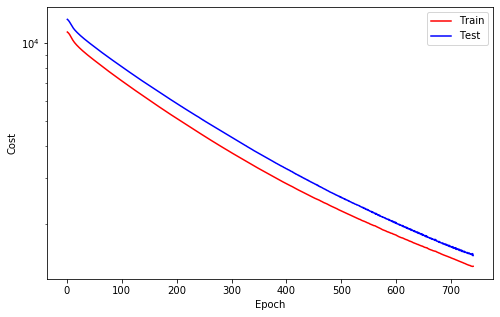



Epoch   741
Train_cost  = 1365.8940 | Test_cost  = 1513.7252 | 
==> EarlyStop patience =  1 | Best test_cost: 1508.9314




Epoch   742
Train_cost  = 1362.8588 | Test_cost  = 1525.3025 | 
==> EarlyStop patience =  2 | Best test_cost: 1508.9314




Epoch   743
Train_cost  = 1361.1455 | Test_cost  = 1495.4900 | 




Epoch   744
Train_cost  = 1357.5731 | Test_cost  = 1511.4254 | 
==> EarlyStop patience =  1 | Best test_cost: 1495.4900




Epoch   745
Train_cost  = 1352.8035 | Test_cost  = 1505.5959 | 
==> EarlyStop patience =  2 | Best test_cost: 1495.4900




Epoch   746
Train_cost  = 1348.8756 | Test_cost  = 1493.6583 | 




Epoch   747
Train_cost  = 1346.9478 | Test_cost  = 1510.4102 | 
==> EarlyStop patience =  1 | Best test_cost: 1493.6583




Epoch   748
Train_cost  = 1346.7079 | Test_cost  = 1487.2119 | 




Epoch   749
Train_cost  = 1341.3316 | Test_cost  = 1492.1320 | 
==> EarlyStop patience =  1 | Best test_cost: 1487.2119




Epoch   750
Train_cost  = 1340.0072 | Test_cost  = 1499.5461 | 
==> EarlyStop patience =  2 | Best test_cost: 1487.2119




Epoch   751
Train_cost  = 1341.0600 | Test_cost  = 1483.0916 | 




Epoch   752
Train_cost  = 1335.8539 | Test_cost  = 1479.5350 | 




Epoch   753
Train_cost  = 1331.9705 | Test_cost  = 1498.8411 | 
==> EarlyStop patience =  1 | Best test_cost: 1479.5350




Epoch   754
Train_cost  = 1330.8461 | Test_cost  = 1466.2471 | 




Epoch   755
Train_cost  = 1328.2811 | Test_cost  = 1480.3737 | 
==> EarlyStop patience =  1 | Best test_cost: 1466.2471




Epoch   756
Train_cost  = 1323.6846 | Test_cost  = 1482.7401 | 
==> EarlyStop patience =  2 | Best test_cost: 1466.2471




Epoch   757
Train_cost  = 1322.0464 | Test_cost  = 1459.5898 | 




Epoch   758
Train_cost  = 1319.1263 | Test_cost  = 1478.5165 | 
==> EarlyStop patience =  1 | Best test_cost: 1459.5898




Epoch   759
Train_cost  = 1316.4698 | Test_cost  = 1459.6119 | 
==> EarlyStop patience =  2 | Best test_cost: 1459.5898




Epoch   760
Train_cost  = 1311.9577 | Test_cost  = 1465.4133 | 


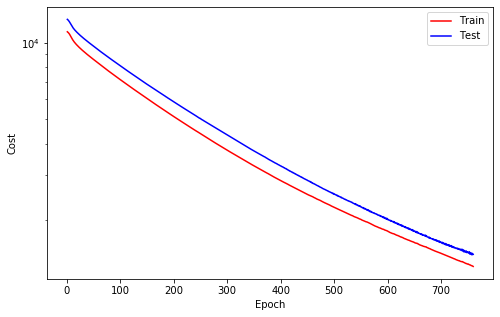

==> EarlyStop patience =  3 | Best test_cost: 1459.5898




Epoch   761
Train_cost  = 1310.3573 | Test_cost  = 1470.4182 | 
==> EarlyStop patience =  4 | Best test_cost: 1459.5898




Epoch   762
Train_cost  = 1310.2119 | Test_cost  = 1460.8186 | 
==> EarlyStop patience =  5 | Best test_cost: 1459.5898
==> Execute Early Stopping at epoch: 762 | Best test_cost: 1459.5898
==> Best model is saved at model


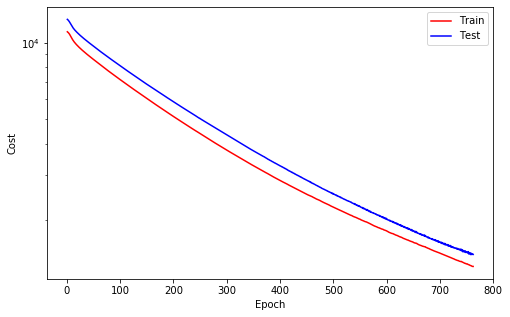

In [55]:
while True :
    train_cost= loop_fn("train",train_set,trainloader,model,criterion,optimizer,device)
    with torch.no_grad():
        test_cost= loop_fn("test",test_set,testloader,model,criterion,optimizer,device)

    callback.log(train_cost, test_cost)


    callback.save_checkpoint()


    callback.cost_runtime_plotting()



    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
        break

In [58]:
from utils import data4pred,pred4pred

In [59]:
train_forecast_set = TimeSeriesDataset(ts_train,"Monthly_Mean_Sunspot",1)
trainforcastloader= DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test,"Monthly_Mean_Sunspot",1)
testforcastloader= DataLoader(test_forecast_set)



(N, S, F): (2611, 1, 1)
Note: last 0 data excluded

(N, S, F): (652, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'test')

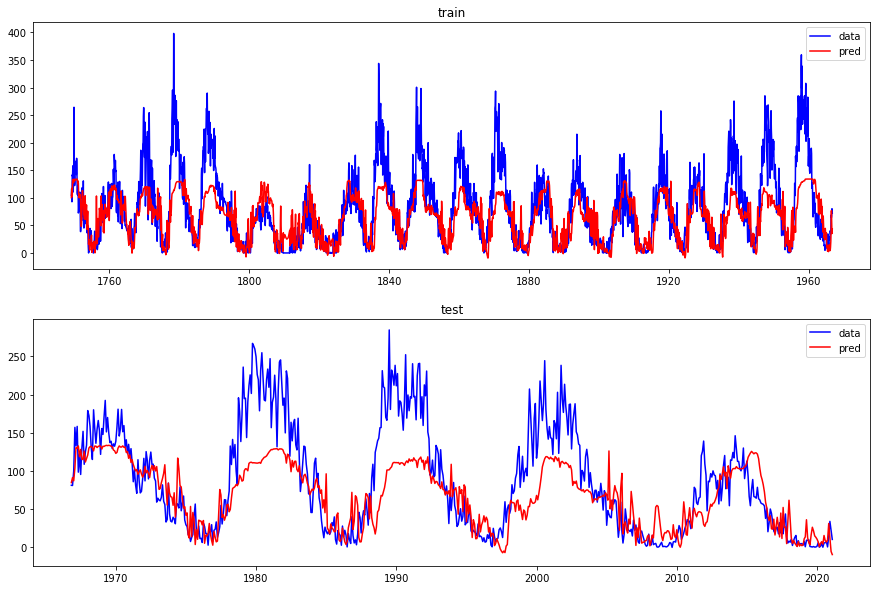

In [60]:
# data4pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model,train_forecast_set,trainforcastloader,device)
plt.title("train")


plt.subplot(212)
data4pred(model,test_forecast_set,testforcastloader,device)
plt.title("test")

Text(0.5, 1.0, 'test')

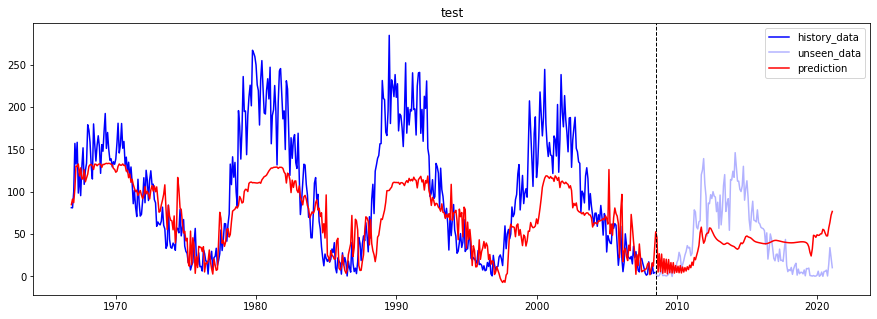

In [61]:
plt.figure(figsize=(15,5))

pred4pred(model,test_forecast_set,testforcastloader,device)
plt.title("test")